In [2]:
import numpy as np
import pandas as pd
import csv
from matplotlib import pyplot as plt
from scipy.integrate import trapz
from scipy.signal import find_peaks
import xarray as xr

# Import Data

In [3]:
%store -r acc_dict
%store -r jerk_normalization
person_names = ["p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13", "p14", "p15", "p16"]
features_dict = {}
participants = pd.read_excel('demographic_data.xlsx')

In [4]:
features = pd.read_excel('sections.xlsx')
start = np.array(features['from_imu']).astype(int)
end = np.array(features['to_imu']).astype(int)
exploratory = np.array(features['exploratory'])
performance = np.array(features['performance'])
double = np.array(features['double'])

section_dict = {}
for i, person_name in enumerate(person_names):
    acc_dataset = acc_dict[person_name]
    features_dict[person_name] = xr.Dataset({'grasping_exploratory': exploratory[i], 'grasping_performance': performance[i], 'grasping_double': double[i]})
    total_time = acc_dataset['time']

    acc_dataset['grasping_exploratory'] = exploratory[i]
    acc_dataset['grasping_performance'] = performance[i]
    acc_dataset['grasping_double'] = double[i]
    section_dict[person_name] = {'start': start[i], 'end': end[i], 'time_1': np.arange(1, start[i]), 'time_2': np.arange(start[i], end[i]), 'time_3': np.arange(end[i], len(total_time) - 1)}

In [5]:
genders = participants['gender']

for i, person_name in enumerate(person_names):
    gender = genders[i]
    features_dict[person_name]['gender'] = gender

In [6]:
def plotFeature(feature):

    values = []
    genders = []

    for person_name, features_dataset in features_dict.items():
        features_dataset = features_dict[person_name]

        values.append(features_dataset[feature])  
        genders.append(features_dataset['gender'].values) 

    genders = [str(gender) for gender in genders]

    # Calculate mean ascent time for women and men
    values = np.array(values)  
    women_values = values[np.array(genders) == 'female']
    men_values = values[np.array(genders) == 'male']

    mean_women = np.mean(women_values)
    mean_men = np.mean(men_values)

    std_women = np.std(women_values)
    std_men = np.std(men_values)

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    colors = {'male': 'blue', 'female': 'red'}
    for person_name, value, gender in zip(person_names, values, genders):
        axs[0].bar(person_name, value, color=colors[gender])
    axs[0].set_ylabel(feature)
    axs[0].set_xticks(np.arange(len(person_names)))
    axs[0].set_xticklabels(person_names, rotation=45, ha='right')

    labels = ['Women', 'Men']
    mean_values = [mean_women, mean_men]
    std_values = [std_women, std_men]
    axs[1].bar(labels, mean_values, yerr=std_values, capsize=10, color=['red', 'blue'])

    axs[2].boxplot([women_values, men_values], labels=['Women', 'Men'])

    plt.tight_layout()
    plt.show()

# Section Extraction
Section 1 - 3 for all axes and the vector of the jerk value

In [7]:
for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]
    features_dataset = features_dict[person_name]
    start = section_dict[person_name]['start']
    end = section_dict[person_name]['end']

    # Trim data
    acc_dataset['section_1_x_jerk_normalized'] = acc_dataset[f'acc_x_derivative_normalized{jerk_normalization}'][0:start]
    acc_dataset['section_2_x_jerk_normalized'] = acc_dataset[f'acc_x_derivative_normalized{jerk_normalization}'][start:end]
    acc_dataset['section_3_x_jerk_normalized'] = acc_dataset[f'acc_x_derivative_normalized{jerk_normalization}'][end:-1]
    acc_dataset['section_1_y_jerk_normalized'] = acc_dataset[f'acc_y_derivative_normalized{jerk_normalization}'][0:start]
    acc_dataset['section_2_y_jerk_normalized'] = acc_dataset[f'acc_y_derivative_normalized{jerk_normalization}'][start:end]
    acc_dataset['section_3_y_jerk_normalized'] = acc_dataset[f'acc_y_derivative_normalized{jerk_normalization}'][end:-1]
    acc_dataset['section_1_z_jerk_normalized'] = acc_dataset[f'acc_z_derivative_normalized{jerk_normalization}'][0:start]
    acc_dataset['section_2_z_jerk_normalized'] = acc_dataset[f'acc_z_derivative_normalized{jerk_normalization}'][start:end]
    acc_dataset['section_3_z_jerk_normalized'] = acc_dataset[f'acc_z_derivative_normalized{jerk_normalization}'][end:-1]
    acc_dataset['section_1_vector_jerk_normalized'] = acc_dataset[f'acc_vector_derivative_normalized{jerk_normalization}'][0:start]
    acc_dataset['section_2_vector_jerk_normalized'] = acc_dataset[f'acc_vector_derivative_normalized{jerk_normalization}'][start:end]
    acc_dataset['section_3_vector_jerk_normalized'] = acc_dataset[f'acc_vector_derivative_normalized{jerk_normalization}'][end:-1]
    features_dataset['time_1'] = start / 120
    features_dataset['time_2'] = (end - start) / 120
    features_dataset['time_3'] = (len(acc_dataset['section_3_vector_jerk_normalized']) - end) / 120

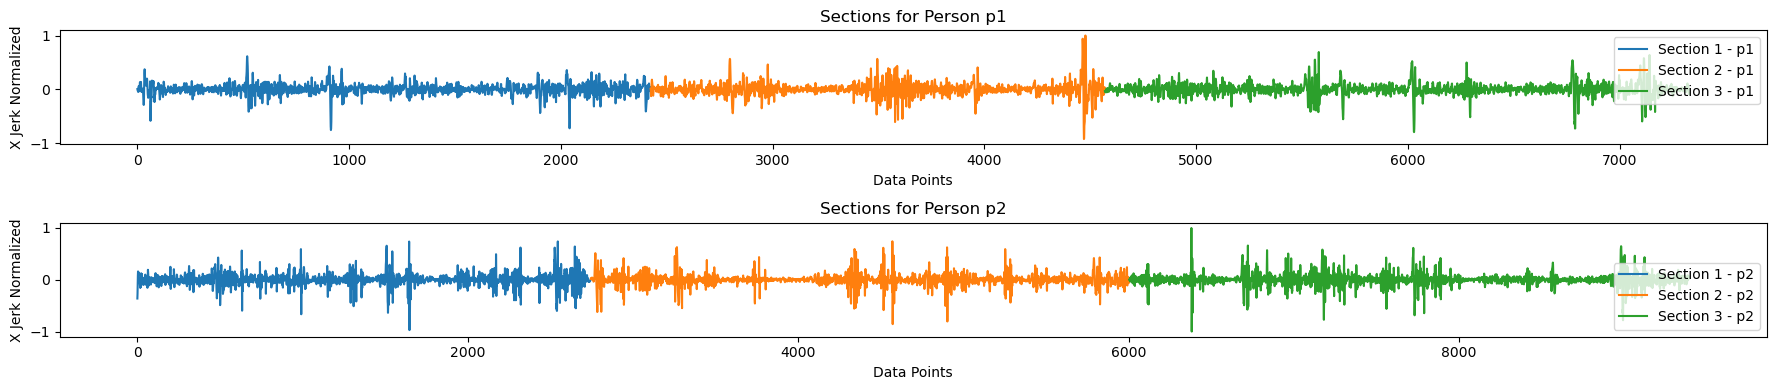

In [8]:
# Extract the data for person p1
p1_section1 = acc_dict['p1']['section_1_vector_jerk_normalized']
p1_section2 = acc_dict['p1']['section_2_vector_jerk_normalized']
p1_section3 = acc_dict['p1']['section_3_vector_jerk_normalized']

# Extract the data for person p2
p2_section1 = acc_dict['p2']['section_1_vector_jerk_normalized']
p2_section2 = acc_dict['p2']['section_2_vector_jerk_normalized']
p2_section3 = acc_dict['p2']['section_3_vector_jerk_normalized']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 4))

# Plot data for person p1
ax1.plot(p1_section1, label='Section 1 - p1')
ax1.plot(p1_section2, label='Section 2 - p1')
ax1.plot(p1_section3, label='Section 3 - p1')
ax1.set_title('Sections for Person p1')
ax1.set_xlabel('Data Points')
ax1.set_ylabel('X Jerk Normalized')
ax1.legend()

# Plot data for person p2
ax2.plot(p2_section1, label='Section 1 - p2')
ax2.plot(p2_section2, label='Section 2 - p2')
ax2.plot(p2_section3, label='Section 3 - p2')
ax2.set_title('Sections for Person p2')
ax2.set_xlabel('Data Points')
ax2.set_ylabel('X Jerk Normalized')
ax2.legend()

plt.tight_layout()
plt.show()


# Mean Squared Jerk
## Calculation
Computation for all axes and the vector for all sections

In [9]:
jerk_values = {'section_1_x': {}, 'section_1_y': {}, 'section_1_z': {}, 'section_1_vector': {}, 
               'section_2_x': {}, 'section_2_y': {}, 'section_2_z': {}, 'section_2_vector': {}, 
               'section_3_x': {}, 'section_3_y': {}, 'section_3_z': {}, 'section_3_vector': {}}

for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]
    section_dataset = section_dict[person_name]
    features_dataset = features_dict[person_name]
    time = acc_dataset['time']
    time_1 = section_dataset['time_1'] 
    time_2 = section_dataset['time_2'] 
    time_3 = section_dataset['time_3'] 
    start_section_2 = len(time_1) + 1
    start_section_3 = len(time_1) + len(time_2) + 1
    ascent_time_1 = (len(time_1)) / 120
    ascent_time_2 = (len(time_2)) / 120
    ascent_time_3 = (len(time_3)) / 120

    # Overall Mean Jerk
    features_dataset['mean_jerk_x'] = acc_dataset['mean_jerk_acc_x']
    features_dataset['mean_jerk_y'] = acc_dataset['mean_jerk_acc_y']
    features_dataset['mean_jerk_z'] = acc_dataset['mean_jerk_acc_z']
    features_dataset['mean_jerk_vector'] = acc_dataset['mean_jerk_acc_vector']

    # Calculate Jerk for each Section
    for axis in ['x', 'y', 'z', 'vector']:
        features_dataset = features_dict[person_name]
        acc_data = acc_dict[person_name]
        C_1 = ascent_time_1 ** 5 / 4 ** 2
        C_2 = ascent_time_2 ** 5 / 4 ** 2
        C_3 = ascent_time_3 ** 5 / 4 ** 2
        section1 = acc_dataset[f'section_1_{axis}_jerk_normalized'][0:len(time_1)]
        section2 = acc_dataset[f'section_2_{axis}_jerk_normalized'][start_section_2  : start_section_3]
        section3 = acc_dataset[f'section_3_{axis}_jerk_normalized'][start_section_3 : len(time_1) + len(time_2) + len(time_3) + 1]
        
        # Integrate 
        integral_value_1 = trapz(section1 ** 2, time_1)
        integral_value_2 = trapz(section2 ** 2, time_2)
        integral_value_3 = trapz(section3 ** 2, time_3)
        mean_jerk_1 = C_1 * integral_value_1 
        mean_jerk_2 = C_2 * integral_value_2 
        mean_jerk_3 = C_3 * integral_value_3 

        jerk_values[f'section_1_{axis}'][person_name] = mean_jerk_1
        jerk_values[f'section_2_{axis}'][person_name] = mean_jerk_2
        jerk_values[f'section_3_{axis}'][person_name] = mean_jerk_3

        features_dataset[f'mean_jerk_1_{axis}'] = mean_jerk_1
        features_dataset[f'mean_jerk_2_{axis}'] = mean_jerk_2
        features_dataset[f'mean_jerk_3_{axis}'] = mean_jerk_3
        acc_data['time_1'] = ascent_time_1
        acc_data['time_2'] = ascent_time_2
        acc_data['time_3'] = ascent_time_3

## Plotting

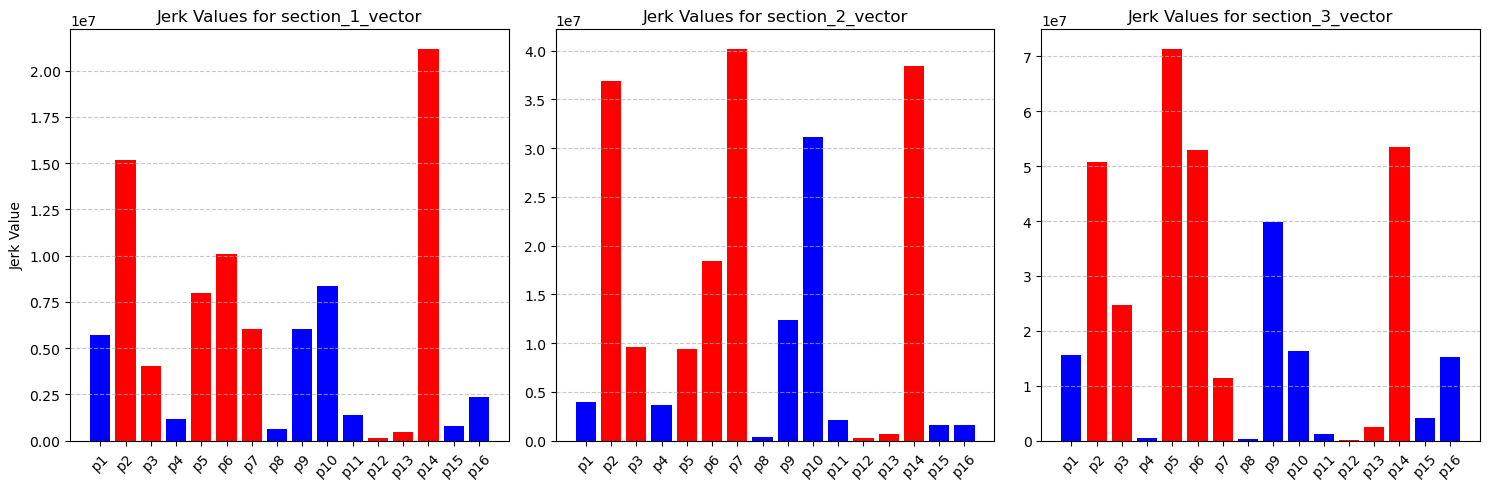

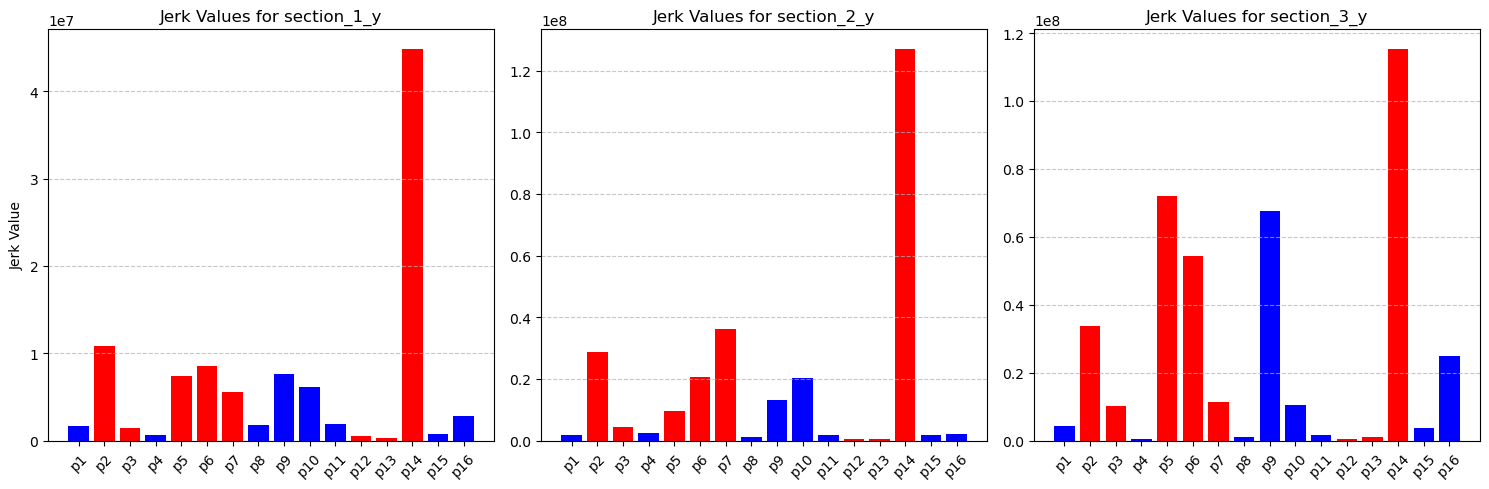

In [10]:
axes = ['section_1_vector', 'section_2_vector', 'section_3_vector']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, axis in enumerate(axes):
    person_names = list(jerk_values[axis].keys())
    values = list(jerk_values[axis].values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    # Define colors based on gender
    colors = ['red' if gender == 'female' else 'blue' for gender in genders]
    axs[i].bar(person_names, values, color=colors)
    axs[i].set_title(f'Jerk Values for {axis}')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

axs[0].set_ylabel('Jerk Value')
plt.tight_layout()
plt.show()

axes_x = ['section_1_y', 'section_2_y', 'section_3_y']
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, axis in enumerate(axes_x):
    person_names = list(jerk_values[axis].keys())
    values = list(jerk_values[axis].values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    # Define colors based on gender
    colors = ['red' if gender == 'female' else 'blue' for gender in genders]
    axs[i].bar(person_names, values, color=colors)
    axs[i].set_title(f'Jerk Values for {axis}')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

axs[0].set_ylabel('Jerk Value')
plt.tight_layout()
plt.show()

In [11]:
jerk_values_women = {'section_1_x': [], 'section_1_y': [], 'section_1_z': [], 'section_1_vector': [], 
                     'section_2_x': [], 'section_2_y': [], 'section_2_z': [], 'section_2_vector': [], 
                     'section_3_x': [], 'section_3_y': [], 'section_3_z': [], 'section_3_vector': []}
jerk_values_men = {'section_1_x': [], 'section_1_y': [], 'section_1_z': [], 'section_1_vector': [], 
                   'section_2_x': [], 'section_2_y': [], 'section_2_z': [], 'section_2_vector': [], 
                   'section_3_x': [], 'section_3_y': [], 'section_3_z': [], 'section_3_vector': []}

for axis, values in jerk_values.items():
    person_names = list(values.keys())
    values = list(values.values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    for person_name, jerk_value, gender in zip(person_names, values, genders):
        if gender == 'female':
            jerk_values_women[axis].append(jerk_value)
        elif gender == 'male':
            jerk_values_men[axis].append(jerk_value)

mean_jerk_values_women = {axis: np.mean(values) for axis, values in jerk_values_women.items()}
std_jerk_values_women = {axis: np.std(values) for axis, values in jerk_values_women.items()}
mean_jerk_values_men = {axis: np.mean(values) for axis, values in jerk_values_men.items()}
std_jerk_values_men = {axis: np.std(values) for axis, values in jerk_values_men.items()}

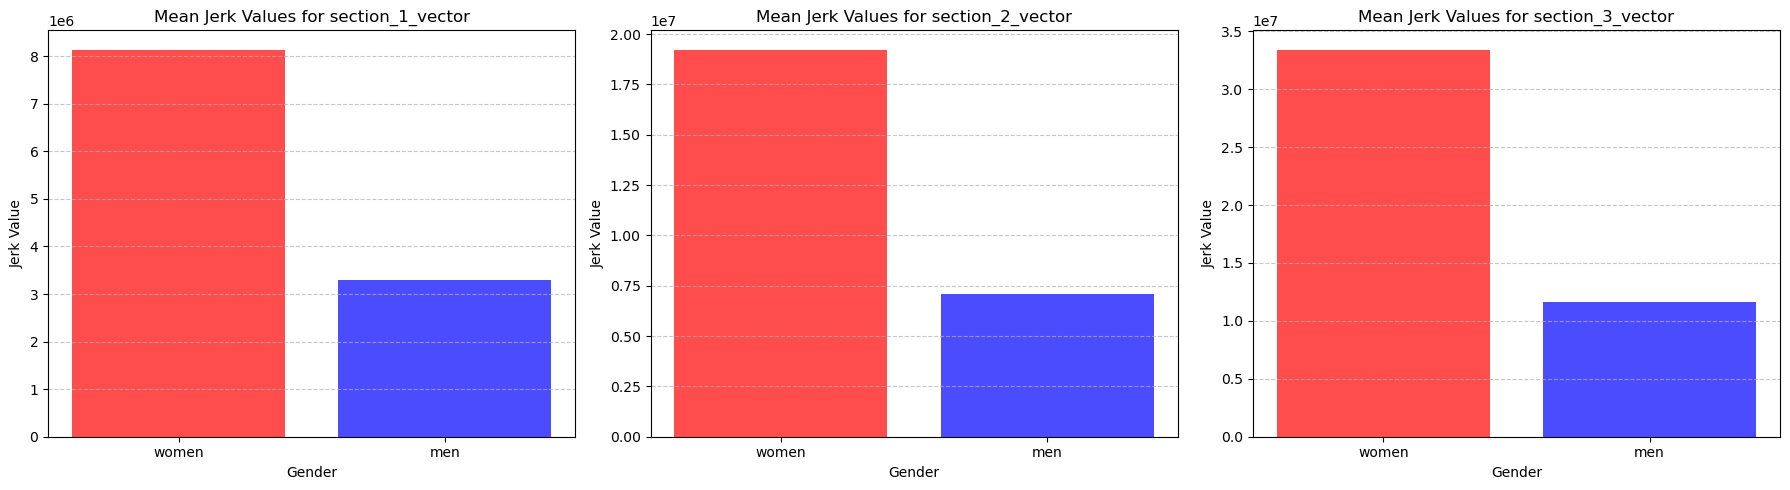

In [12]:
axes = ['section_1_vector', 'section_2_vector', 'section_3_vector']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, axis in enumerate(axes):
    x_labels = ['women', 'men']
    x = range(len(x_labels))
    y_mean_values = [mean_jerk_values_women[axis], mean_jerk_values_men[axis]]
    y_std_values = [std_jerk_values_women[axis], std_jerk_values_men[axis]]
    
    # Define the colors for women and men
    colors = ['red', 'blue']
    axs[i].bar(x, y_mean_values, color=colors, alpha=0.7, capsize=5)
    
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(x_labels)
    axs[i].set_xlabel('Gender')
    axs[i].set_ylabel('Jerk Value')
    axs[i].set_title(f'Mean Jerk Values for {axis}')
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

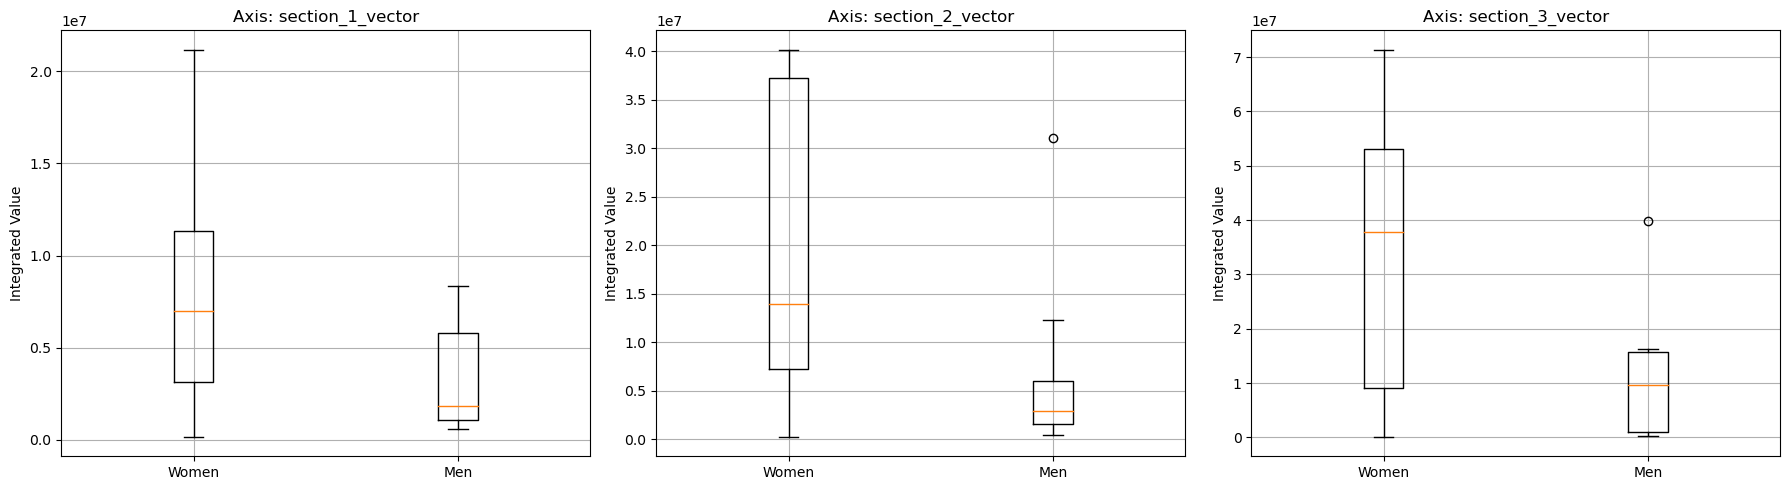

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, axis in enumerate(['section_1_vector', 'section_2_vector', 'section_3_vector']):
    person_names = list(jerk_values[axis].keys())
    values = list(jerk_values[axis].values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]

    plot_jerk_values_women = [values[j] for j, gender in enumerate(genders) if gender == 'female']
    plot_jerk_values_men = [values[j] for j, gender in enumerate(genders) if gender == 'male']
    
    positions = [1, 2]
    axs[i].boxplot([plot_jerk_values_women, plot_jerk_values_men], positions=positions, labels=['Women', 'Men'])
    axs[i].set_ylabel('Integrated Value')
    axs[i].set_title(f'Axis: {axis}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Feature Peaks
Normalize locally for each section in order to best find the peaks

In [14]:
for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]
    section1 = acc_dataset[f'section_1_vector_jerk_normalized{jerk_normalization}']
    section2 = acc_dataset[f'section_2_vector_jerk_normalized{jerk_normalization}']
    section3 = acc_dataset[f'section_3_vector_jerk_normalized{jerk_normalization}']
    
    max1 = np.max(np.abs(section1))
    max2 = np.max(np.abs(section2))
    max3 = np.max(np.abs(section3))
    
    section1_normalized = section1 / max1
    section2_normalized = section2 / max2
    section3_normalized = section3 / max3
    
    acc_dataset['section_1_normalized'] = section1_normalized
    acc_dataset['section_2_normalized'] = section2_normalized
    acc_dataset['section_3_normalized'] = section3_normalized

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 1: 0.3045025826296923
Number of positive peaks in Section 1: 17
Number of negative peaks in Section 1: 24
Square root of mean value for Section 2: 0.28051750150003746
Number of positive peaks in Section 2: 18
Number of negative peaks in Section 2: 18


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 3: 0.3052598261911047
Number of positive peaks in Section 3: 22
Number of negative peaks in Section 3: 23


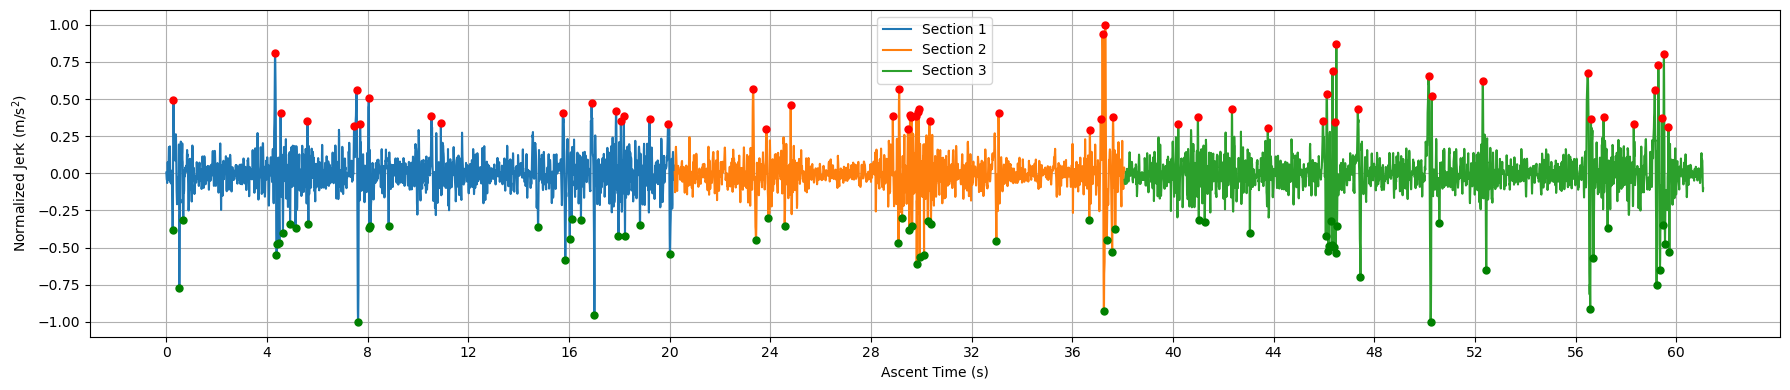

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 1: 0.27487217090453986
Number of positive peaks in Section 1: 28
Number of negative peaks in Section 1: 45
Square root of mean value for Section 2: 0.27719242313667675
Number of positive peaks in Section 2: 42
Number of negative peaks in Section 2: 44


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 3: 0.25949525267831763
Number of positive peaks in Section 3: 41
Number of negative peaks in Section 3: 38


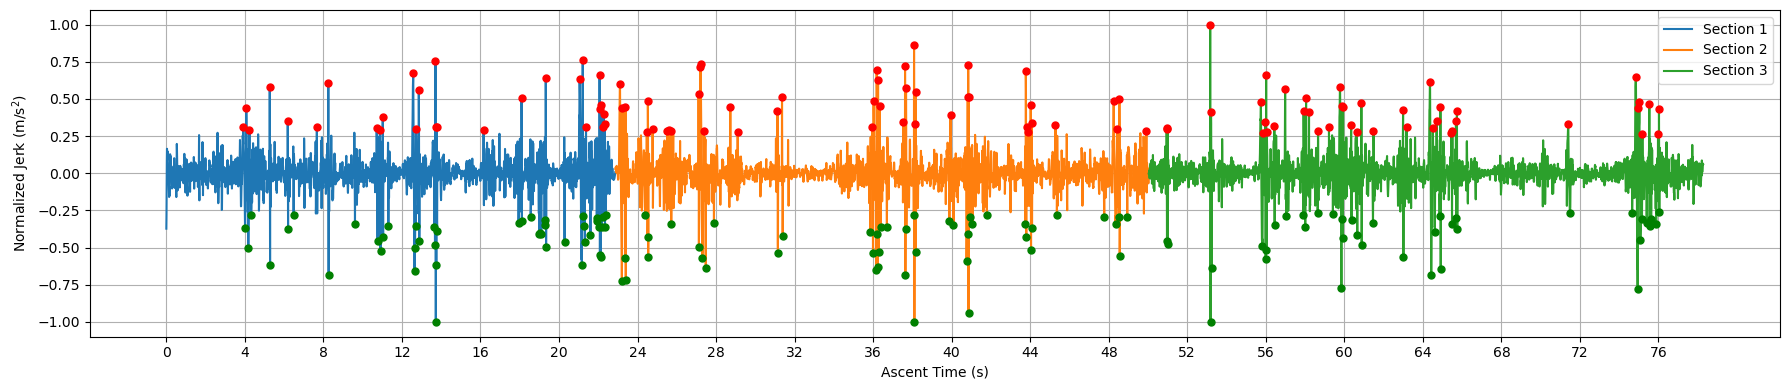

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 1: 0.27161066105721815
Number of positive peaks in Section 1: 25
Number of negative peaks in Section 1: 22
Square root of mean value for Section 2: 0.33804900084446815
Number of positive peaks in Section 2: 36
Number of negative peaks in Section 2: 36


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 3: 0.20459582623659545
Number of positive peaks in Section 3: 16
Number of negative peaks in Section 3: 21


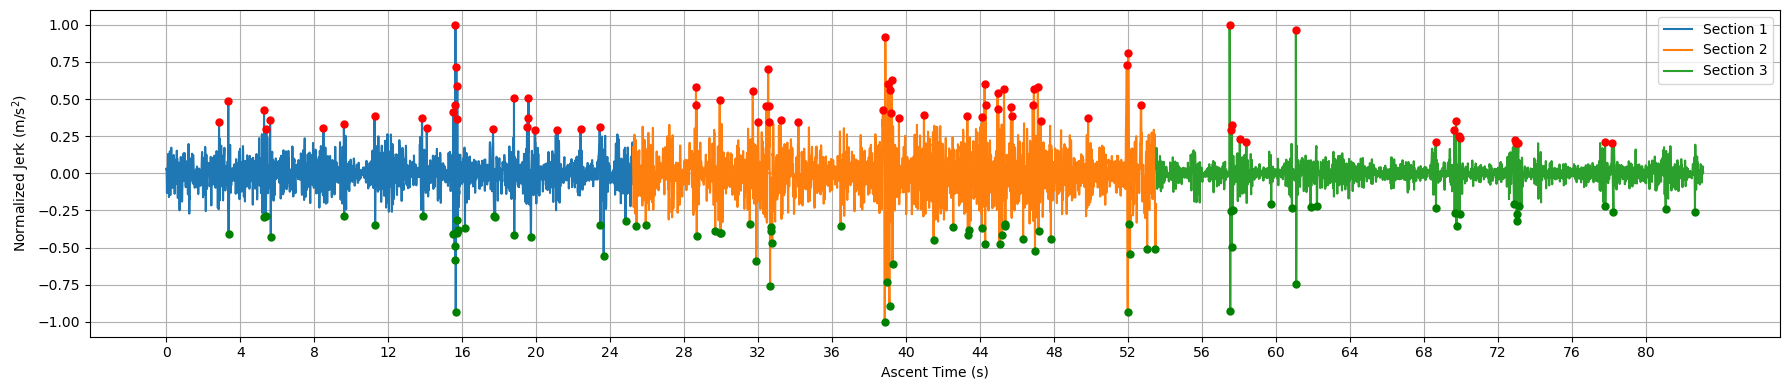

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 1: 0.38565748216844686
Number of positive peaks in Section 1: 35
Number of negative peaks in Section 1: 28
Square root of mean value for Section 2: 0.317185862471838
Number of positive peaks in Section 2: 21
Number of negative peaks in Section 2: 19


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 3: 0.43116431437896013
Number of positive peaks in Section 3: 36
Number of negative peaks in Section 3: 38


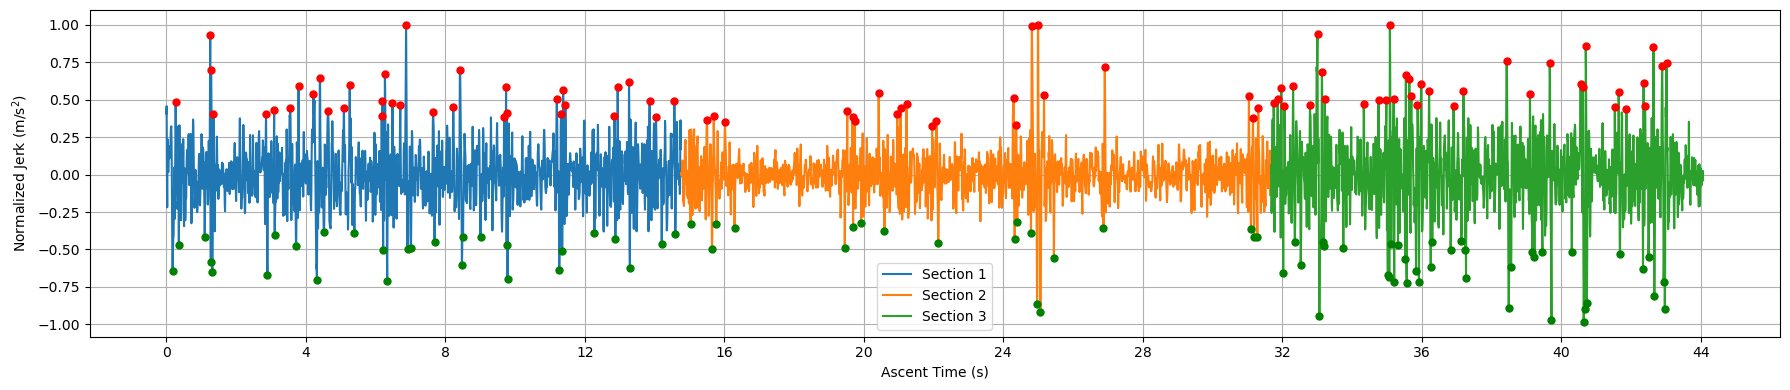

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 1: 0.3725308030314582
Number of positive peaks in Section 1: 32
Number of negative peaks in Section 1: 38


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 2: 0.39344026611114985
Number of positive peaks in Section 2: 42
Number of negative peaks in Section 2: 46
Square root of mean value for Section 3: 0.39959409976402405
Number of positive peaks in Section 3: 59
Number of negative peaks in Section 3: 58


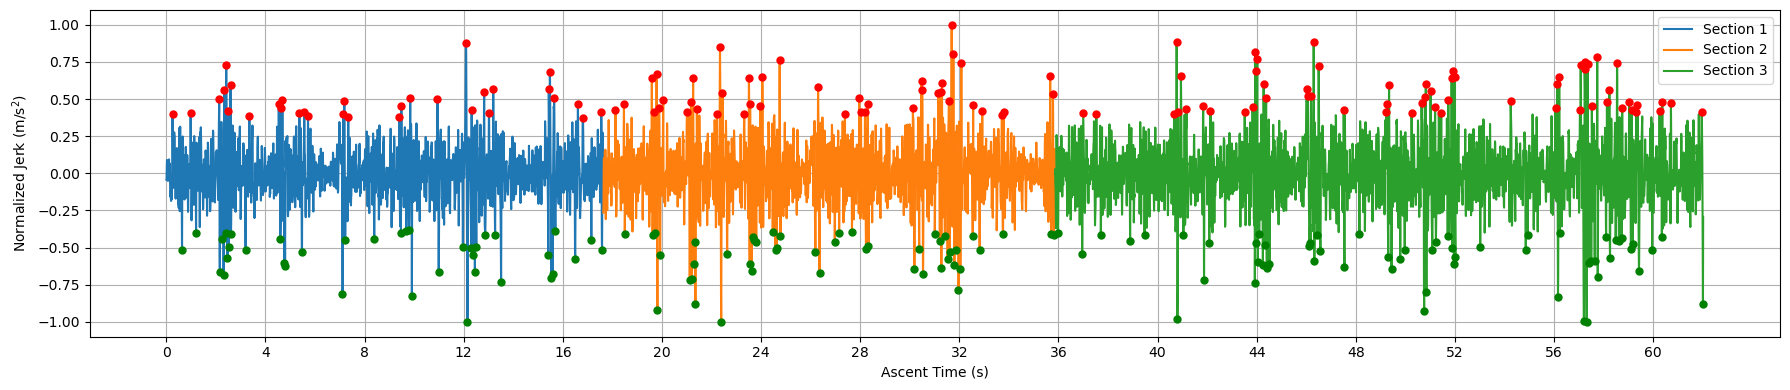

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 1: 0.3544085040976442
Number of positive peaks in Section 1: 30
Number of negative peaks in Section 1: 35


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 2: 0.3827104693731338
Number of positive peaks in Section 2: 41
Number of negative peaks in Section 2: 49


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 3: 0.360163428073758
Number of positive peaks in Section 3: 47
Number of negative peaks in Section 3: 48


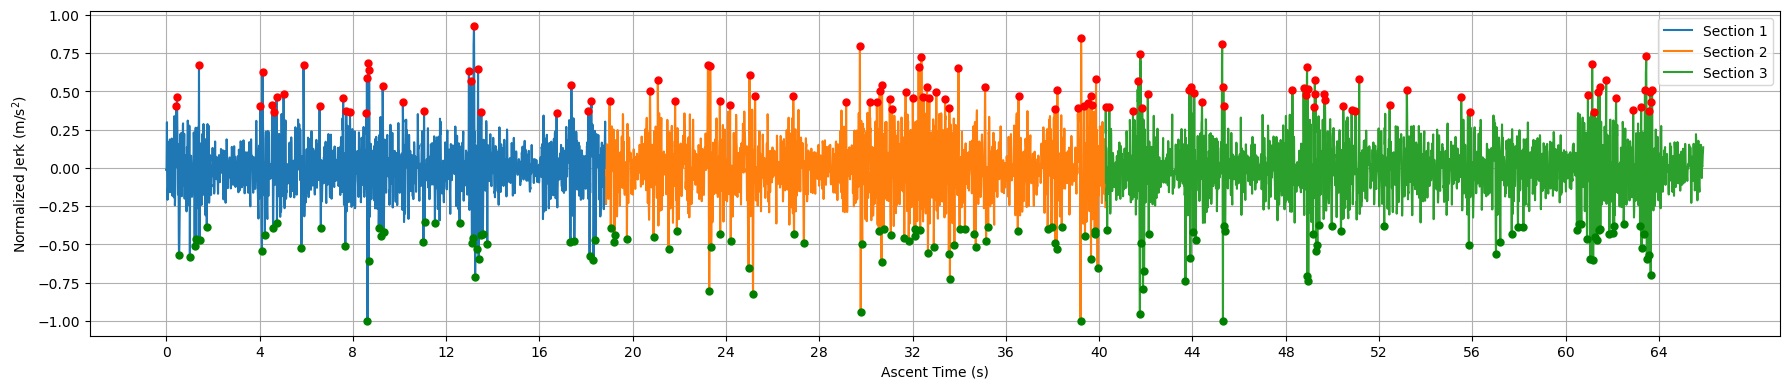

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 1: 0.2396620959659049
Number of positive peaks in Section 1: 18
Number of negative peaks in Section 1: 21
Square root of mean value for Section 2: 0.26951613289670695
Number of positive peaks in Section 2: 34
Number of negative peaks in Section 2: 36


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 3: 0.22669754368754588
Number of positive peaks in Section 3: 22
Number of negative peaks in Section 3: 23


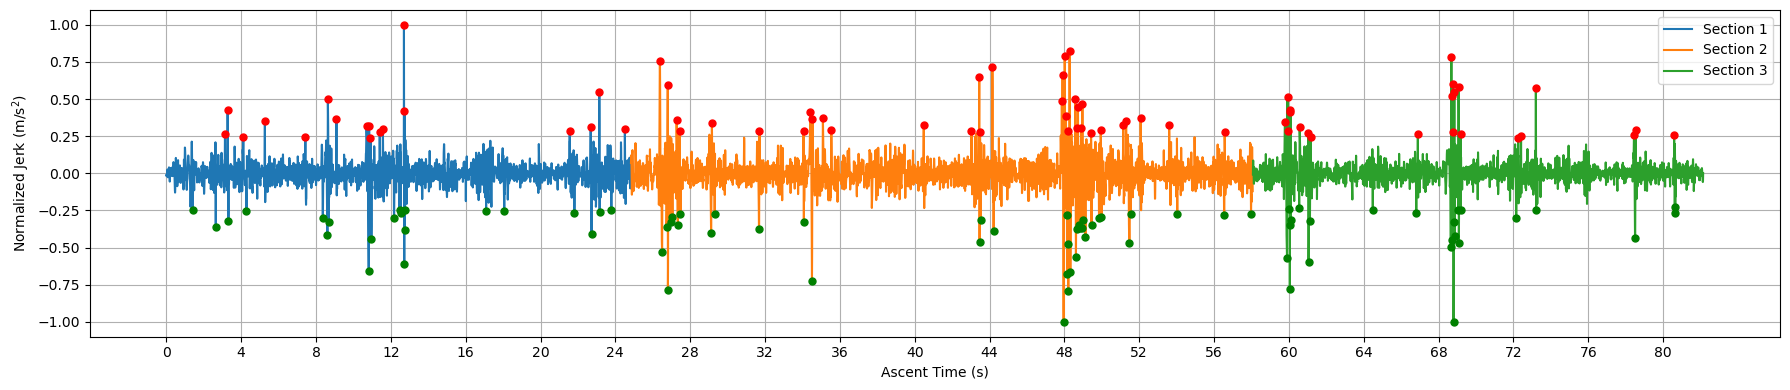

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 1: 0.22318906957289708
Number of positive peaks in Section 1: 10
Number of negative peaks in Section 1: 5
Square root of mean value for Section 2: 0.2991381454354569
Number of positive peaks in Section 2: 18
Number of negative peaks in Section 2: 13


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 3: 0.343579637006731
Number of positive peaks in Section 3: 16
Number of negative peaks in Section 3: 17


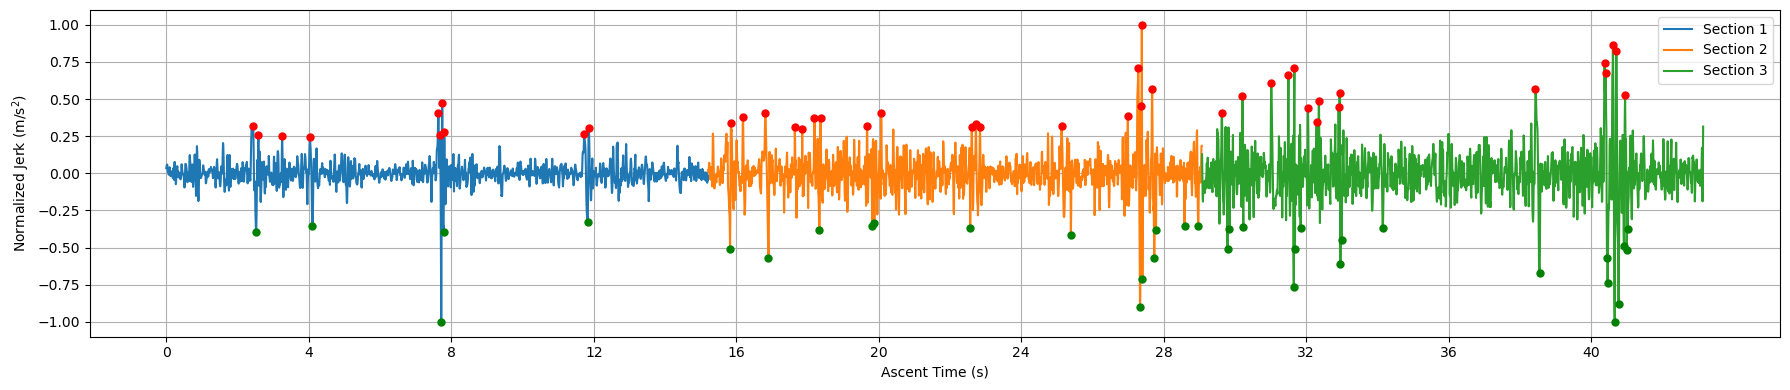

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 1: 0.3388009815646014
Number of positive peaks in Section 1: 34
Number of negative peaks in Section 1: 27
Square root of mean value for Section 2: 0.2663655126303198
Number of positive peaks in Section 2: 25
Number of negative peaks in Section 2: 25


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 3: 0.2526457892382931
Number of positive peaks in Section 3: 20
Number of negative peaks in Section 3: 22


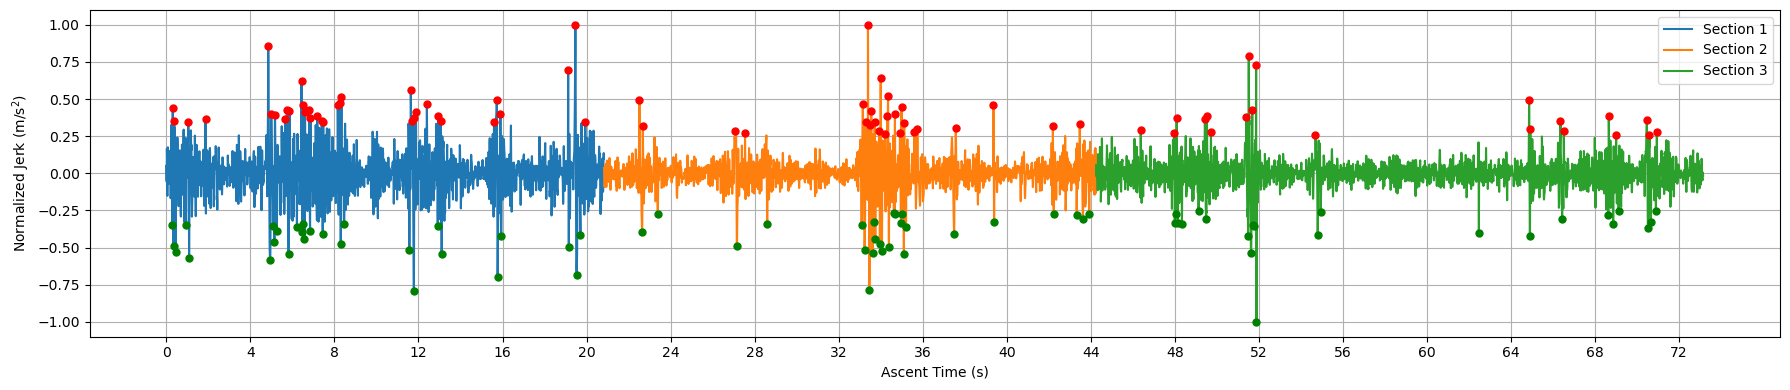

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 1: 0.3038549045063676
Number of positive peaks in Section 1: 27
Number of negative peaks in Section 1: 27
Square root of mean value for Section 2: 0.27030068365819937
Number of positive peaks in Section 2: 22
Number of negative peaks in Section 2: 18


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 3: 0.36828129388047665
Number of positive peaks in Section 3: 35
Number of negative peaks in Section 3: 45


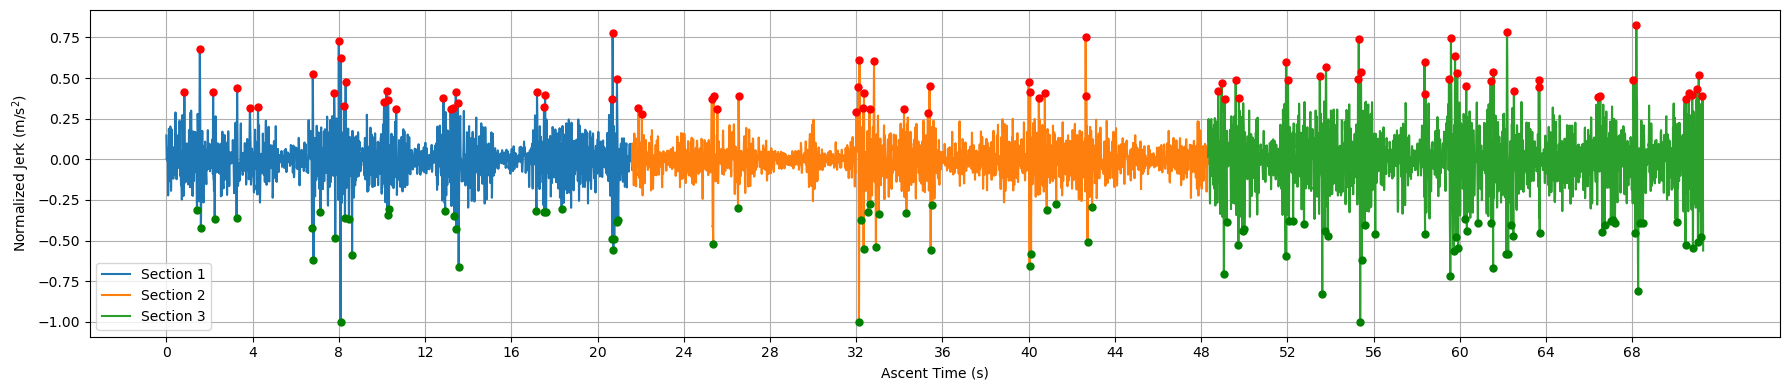

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 1: 0.15430392450725516
Number of positive peaks in Section 1: 6
Number of negative peaks in Section 1: 8


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 2: 0.1835083744706394
Number of positive peaks in Section 2: 15
Number of negative peaks in Section 2: 15
Square root of mean value for Section 3: 0.2448587283118802
Number of positive peaks in Section 3: 22
Number of negative peaks in Section 3: 22


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


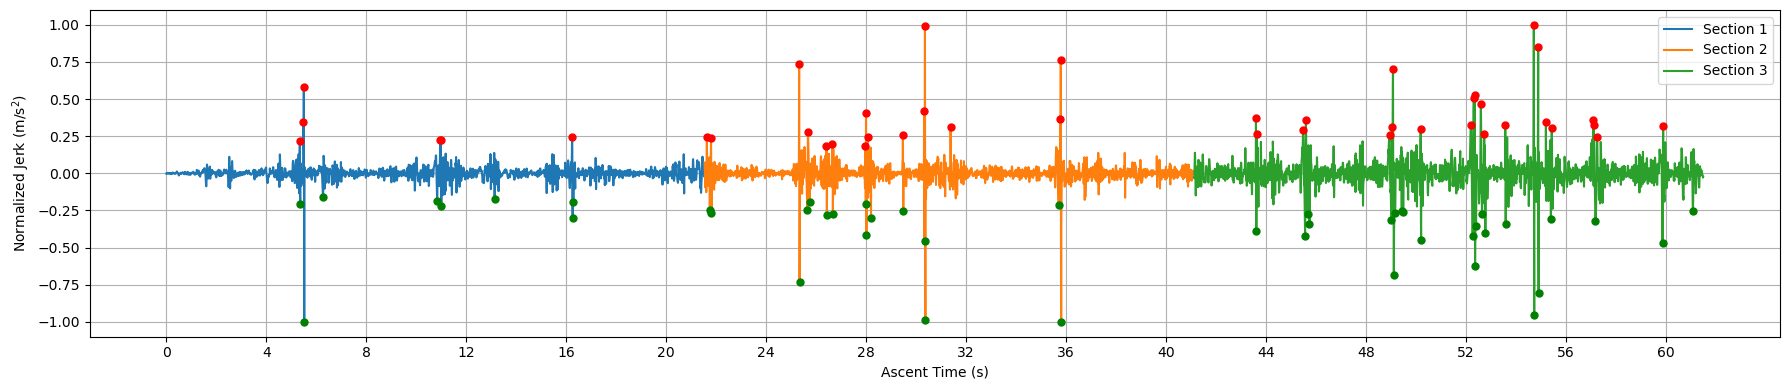

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 1: 0.3021314426647108
Number of positive peaks in Section 1: 19
Number of negative peaks in Section 1: 10
Square root of mean value for Section 2: 0.2110738223834727
Number of positive peaks in Section 2: 6
Number of negative peaks in Section 2: 4


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 3: 0.34701744741430257
Number of positive peaks in Section 3: 19
Number of negative peaks in Section 3: 20


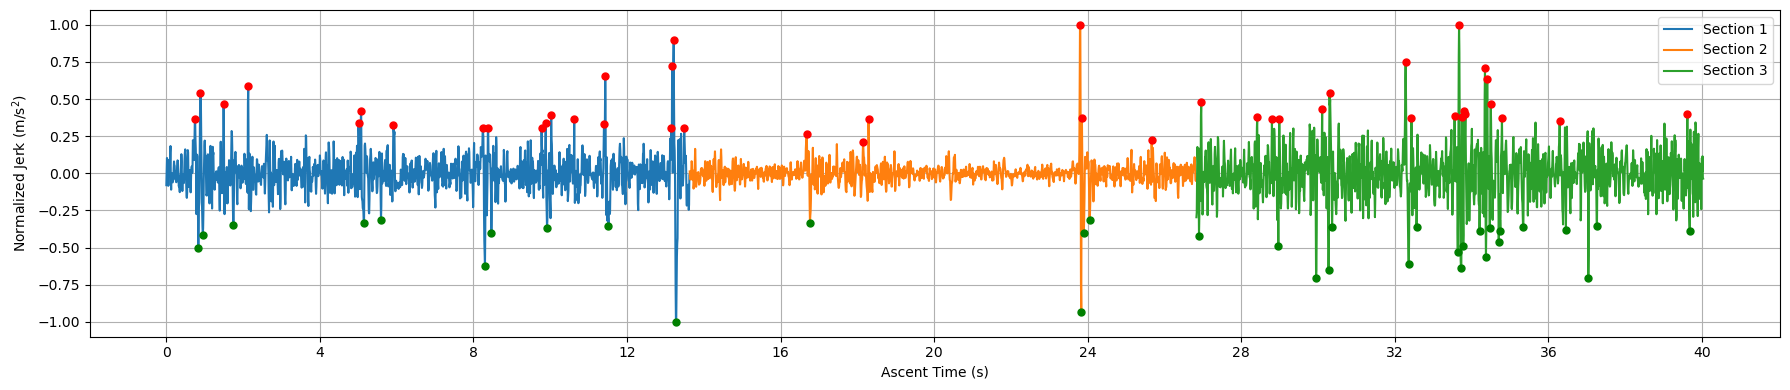

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 1: 0.32763331154029574
Number of positive peaks in Section 1: 18
Number of negative peaks in Section 1: 13
Square root of mean value for Section 2: 0.24688832038948288
Number of positive peaks in Section 2: 7
Number of negative peaks in Section 2: 6


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 3: 0.23739066255004365
Number of positive peaks in Section 3: 10
Number of negative peaks in Section 3: 8


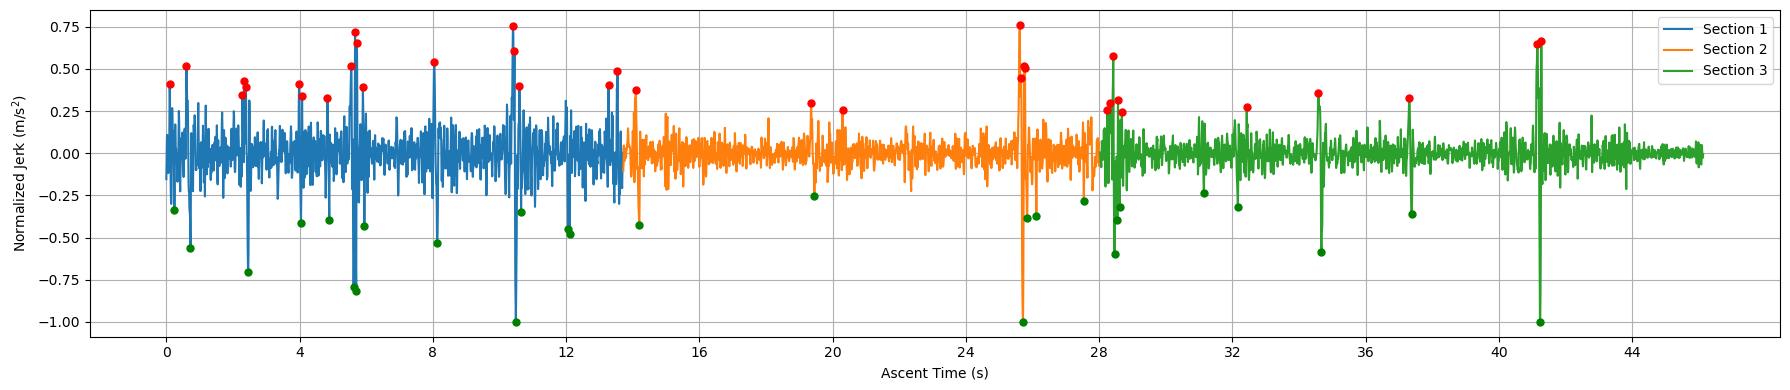

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 1: 0.33522393704238757
Number of positive peaks in Section 1: 37
Number of negative peaks in Section 1: 41
Square root of mean value for Section 2: 0.2878384967818669
Number of positive peaks in Section 2: 23
Number of negative peaks in Section 2: 29


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 3: 0.22689716138221466
Number of positive peaks in Section 3: 11
Number of negative peaks in Section 3: 11


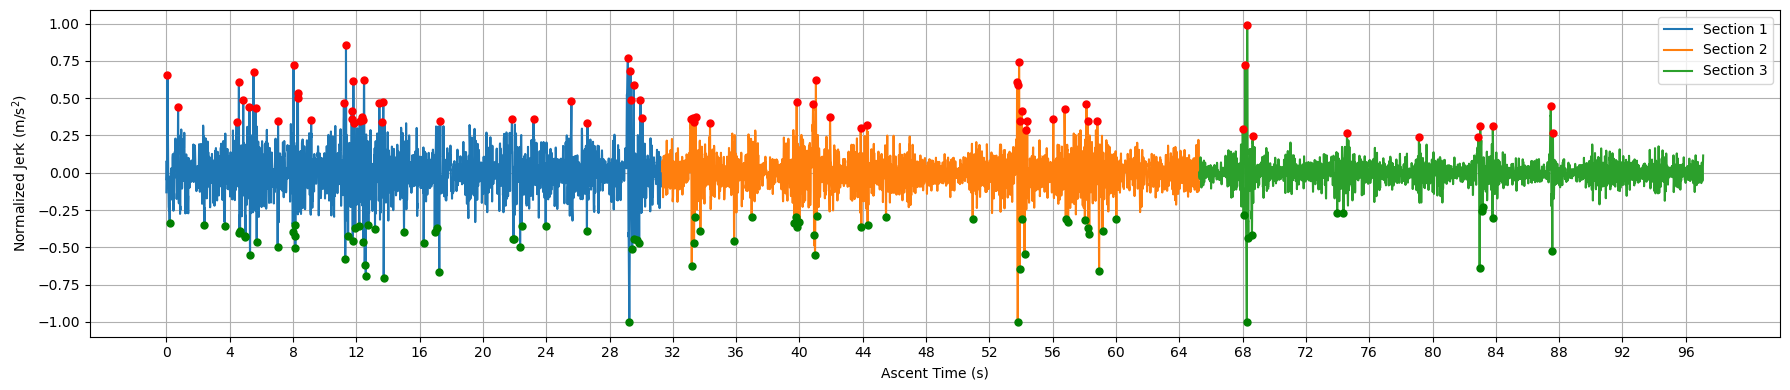

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 1: 0.31407875757029363
Number of positive peaks in Section 1: 24
Number of negative peaks in Section 1: 18
Square root of mean value for Section 2: 0.20936627794179388
Number of positive peaks in Section 2: 10
Number of negative peaks in Section 2: 13


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Square root of mean value for Section 3: 0.2132043713388475
Number of positive peaks in Section 3: 8
Number of negative peaks in Section 3: 9


In [44]:
def find_and_plot_peaks(data, mean, label):
    mean_sqrt = np.sqrt(mean.values.item())  
    print(f"Square root of mean value for Section {label}: {mean_sqrt}")

    # Find positive peaks
    pos_peaks, _ = find_peaks(data, height=mean_sqrt, prominence=0.1) 
    num_pos_peaks = len(pos_peaks)
    print(f"Number of positive peaks in Section {label}: {num_pos_peaks}")
    plt.plot(pos_peaks, data[pos_peaks], 'ro', markersize=5) 
    
    # Find negative peaks
    neg_peaks, _ = find_peaks(-data, height=mean_sqrt, prominence=0.1)  
    num_neg_peaks = len(neg_peaks)
    print(f"Number of negative peaks in Section {label}: {num_neg_peaks}")
    plt.plot(neg_peaks, data[neg_peaks], 'go', markersize=5) 
    plt.savefig(f'./Peaks/{person_name}.eps')

    # Save 
    acc_data[f'pos_peaks_{label}'] = num_pos_peaks
    acc_data[f'neg_peaks_{label}'] = num_neg_peaks
    features_dict[person_name][f'pos_peaks_{label}'] = num_pos_peaks
    features_dict[person_name][f'neg_peaks_{label}'] = num_neg_peaks

# Calcute mean to use as height
for person_name, acc_data in acc_dict.items():
    section1_data = acc_data['section_1_normalized']
    section2_data = acc_data['section_2_normalized']
    section3_data = acc_data['section_3_normalized']
    section1_mean = np.mean(np.abs(section1_data))
    section2_mean = np.mean(np.abs(section2_data))
    section3_mean = np.mean(np.abs(section3_data))
    
    fig, ax = plt.subplots(1, 1, figsize=(18, 4))
    ax.plot(section1_data, label='Section 1')
    ax.plot(section2_data, label='Section 2')
    ax.plot(section3_data, label='Section 3')
    ax.set_xlabel('Ascent Time (s)')
    ax.set_ylabel('Normalized Jerk (m/s$^2$)')
    ax.legend()
    
    x_ticks = np.arange(0, len(section1_data), 240)
    ax.set_xticks(x_ticks[::2])  
    ax.set_xticklabels(x_ticks[::2] // 120)  
    
    # Find and plot peaks for each section
    for section_data, section_mean, section_label in zip([section1_data, section2_data, section3_data], [section1_mean, section2_mean, section3_mean], ['1', '2', '3']):
        find_and_plot_peaks(section_data, section_mean, section_label)
    
    plt.tight_layout()
    plt.show()

In [16]:
for person_name, features_dataset in features_dict.items():
        features_dataset['pos_peaks'] = features_dataset['pos_peaks_1'] + features_dataset['pos_peaks_2'] + features_dataset['pos_peaks_3']
        features_dataset['neg_peaks'] = features_dataset['neg_peaks_1'] + features_dataset['neg_peaks_2'] + features_dataset['neg_peaks_3']

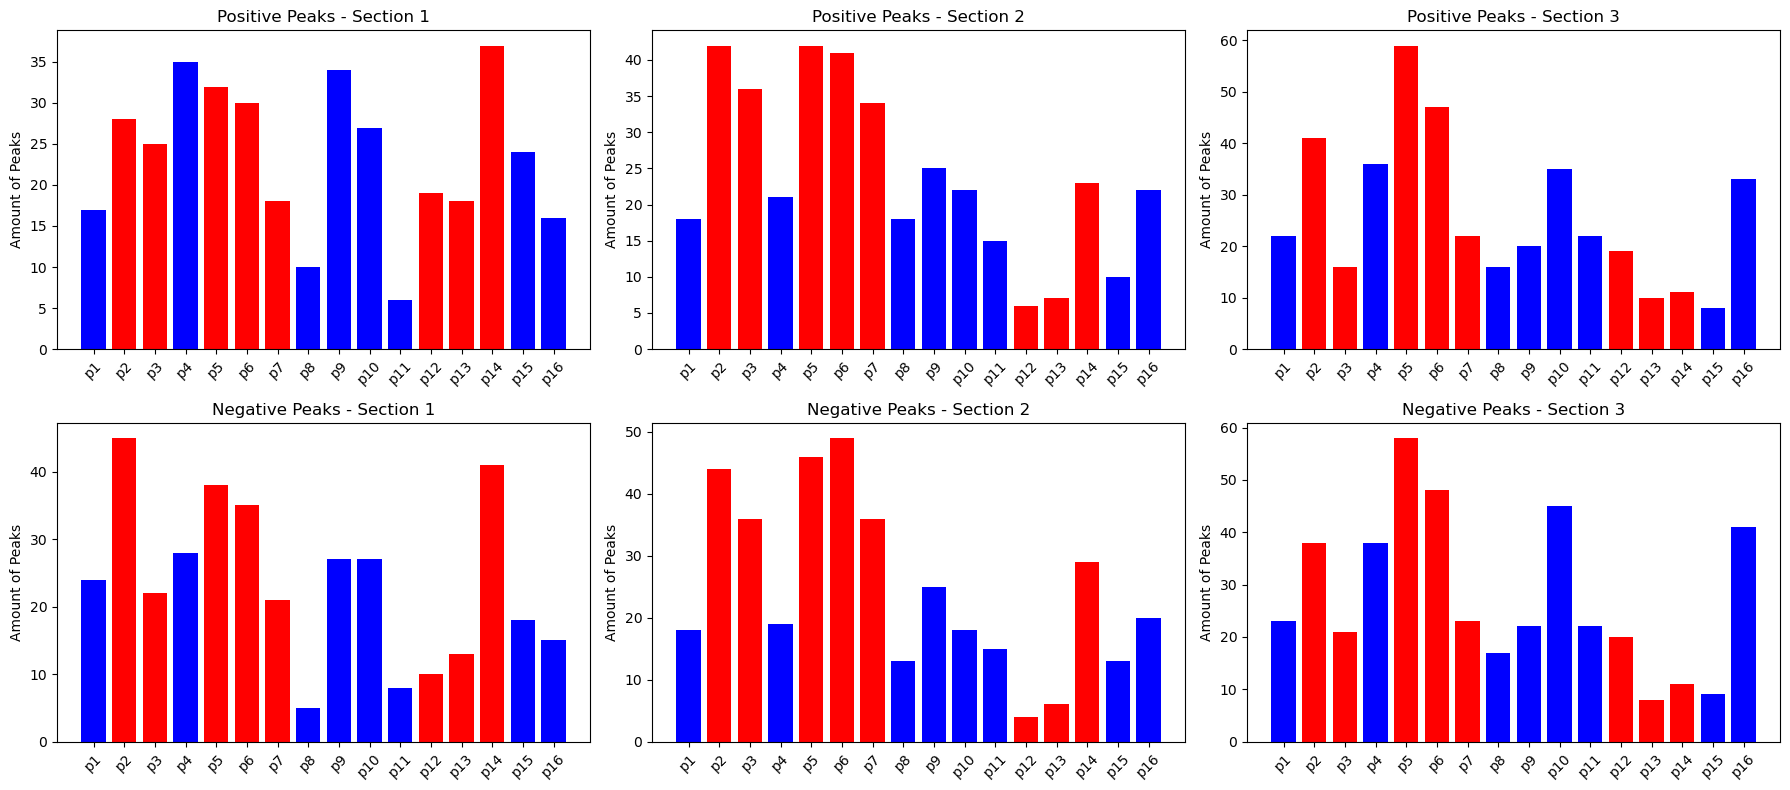

In [17]:
# Initialize 
positive_peak_counts = {'1': [], '2': [], '3': []}
negative_peak_counts = {'1': [], '2': [], '3': []}

for person_name, acc_data in acc_dict.items():
    for section_label in ['1', '2', '3']:
        positive_peak_count_key = f'pos_peaks_{section_label}'
        negative_peak_count_key = f'neg_peaks_{section_label}'
        
        positive_peak_count = acc_data.get(positive_peak_count_key, 0)
        negative_peak_count = acc_data.get(negative_peak_count_key, 0)

        positive_peak_counts[section_label].append(positive_peak_count)
        negative_peak_counts[section_label].append(negative_peak_count)

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Positive Peaks
for i, section_label in enumerate(['1', '2', '3']):
    colors = ['red' if gender == 'female' else 'blue' for gender in genders]
    ax = axes[0, i]
    ax.bar(np.arange(len(positive_peak_counts[section_label])), positive_peak_counts[section_label], color=colors)
    ax.set_title(f'Positive Peaks - Section {section_label}')
    ax.set_ylabel('Amount of Peaks')
    ax.set_xticks(np.arange(len(positive_peak_counts[section_label])))
    ax.set_xticklabels(acc_dict.keys(), rotation=45)

# Negative Peaks
for i, section_label in enumerate(['1', '2', '3']):
    colors = ['red' if gender == 'female' else 'blue' for gender in genders]
    ax = axes[1, i]
    ax.bar(np.arange(len(negative_peak_counts[section_label])), negative_peak_counts[section_label], color=colors)
    ax.set_title(f'Negative Peaks - Section {section_label}')
    ax.set_ylabel('Amount of Peaks')
    ax.set_xticks(np.arange(len(negative_peak_counts[section_label])))
    ax.set_xticklabels(acc_dict.keys(), rotation=45)

plt.tight_layout()
plt.show()

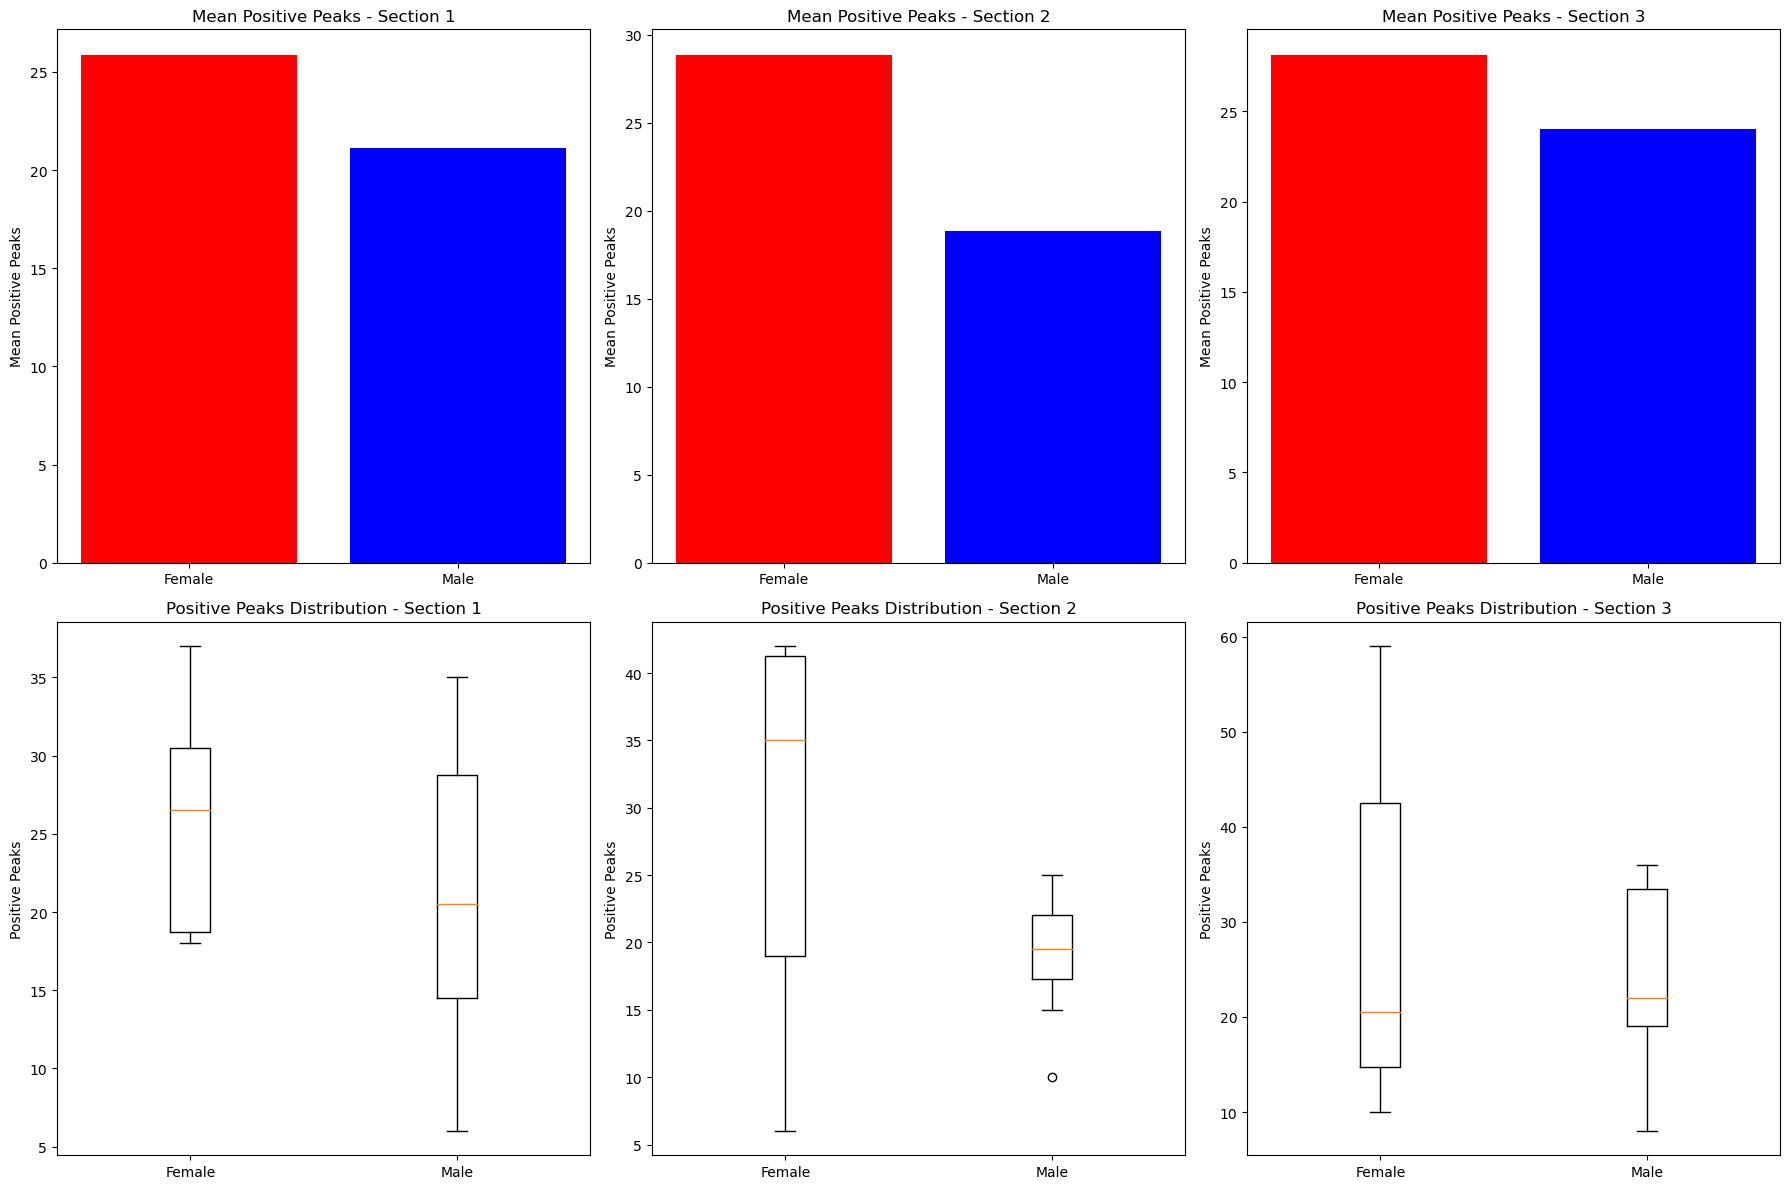

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize 
positive_peak_counts = {'1': {'female': [], 'male': []}, '2': {'female': [], 'male': []}, '3': {'female': [], 'male': []}}

for person_name, acc_data in acc_dict.items():
    gender = acc_data['gender'].item()
    for section_label in ['1', '2', '3']:
        positive_peak_count_key = f'pos_peaks_{section_label}'
        
        positive_peak_count = acc_data[positive_peak_count_key].item()

        positive_peak_counts[section_label][gender].append(positive_peak_count)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plotting mean positive peaks for each section
for i, section_label in enumerate(['1', '2', '3']):
    ax = axes[0, i]
    mean_pos_peaks_female = np.mean(positive_peak_counts[section_label]['female'])
    mean_pos_peaks_male = np.mean(positive_peak_counts[section_label]['male'])
    
    ax.bar(['Female', 'Male'], [mean_pos_peaks_female, mean_pos_peaks_male], color=['red', 'blue'])
    ax.set_title(f'Mean Positive Peaks - Section {section_label}')
    ax.set_ylabel('Mean Positive Peaks')
    
# Plotting boxplots for each section
for i, section_label in enumerate(['1', '2', '3']):
    ax = axes[1, i]
    data_female = positive_peak_counts[section_label]['female']
    data_male = positive_peak_counts[section_label]['male']
    
    ax.boxplot([data_female, data_male], labels=['Female', 'Male'])
    ax.set_title(f'Positive Peaks Distribution - Section {section_label}')
    ax.set_ylabel('Positive Peaks')
    
plt.tight_layout()
plt.show()


# Feature Grasping

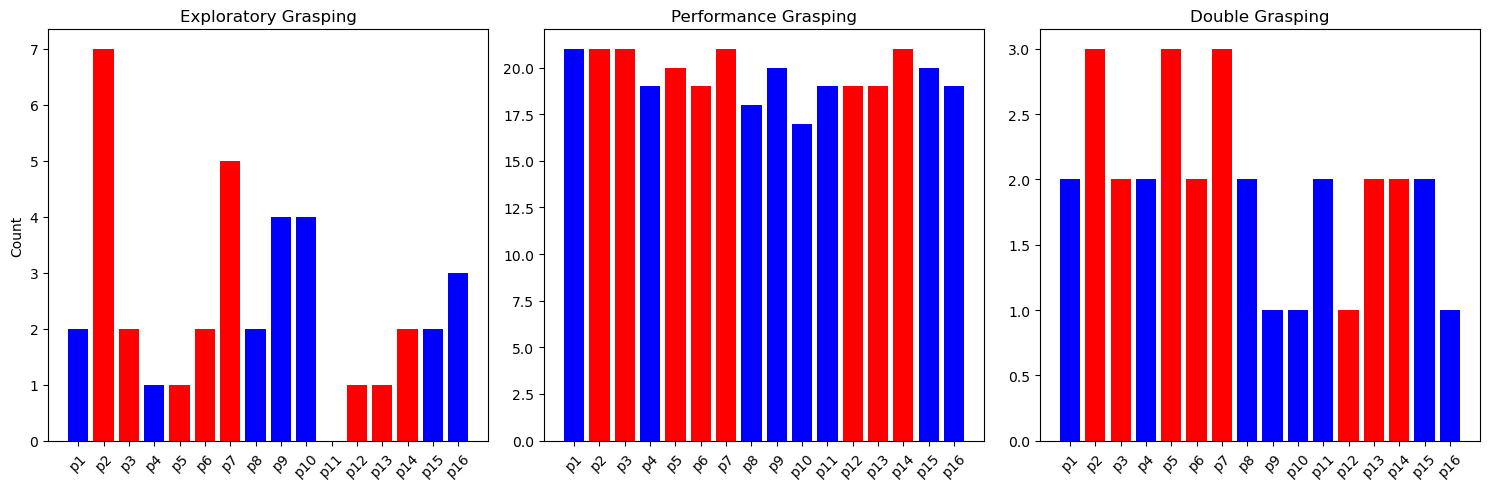

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, grasping_type in enumerate(['grasping_exploratory', 'grasping_performance', 'grasping_double']):
    grasping_values = [acc_dict[person_name][grasping_type] for person_name in person_names]
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    ax = axes[i]
    for person_name, grasping_value, gender in zip(person_names, grasping_values, genders):
        color = 'blue' if gender == 'male' else 'red'
        ax.bar(person_name, grasping_value, color=color)
    
    ax.set_title(f'{grasping_type.split("_")[1].capitalize()} Grasping')
    ax.tick_params(axis='x', rotation=45)

axes[0].set_ylabel('Count')
plt.tight_layout()
plt.show()

# Feature Ascent Time

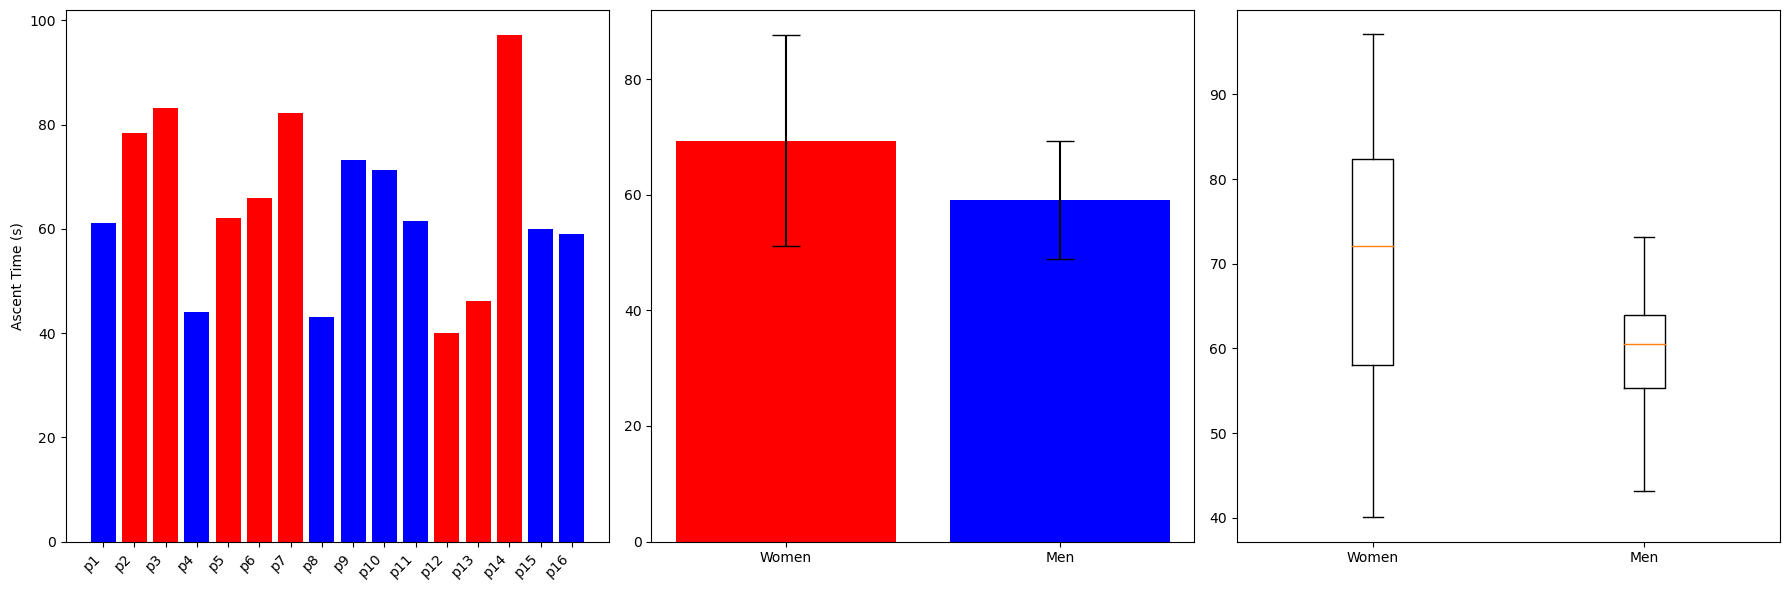

In [20]:
time_values = []
genders = []

for person_name, acc_dataset in acc_dict.items():
    features_dataset = features_dict[person_name]

    ascent_time = acc_dataset['time'][-1] / 120
    features_dataset['time'] = ascent_time
    time_values.append(ascent_time)  # Convert to seconds
    genders.append(acc_dataset['gender'].values)  # Extract gender values

genders = [str(gender) for gender in genders]

# Calculate mean ascent time for women and men
time_values = np.array(time_values)  
women_times = time_values[np.array(genders) == 'female']
men_times = time_values[np.array(genders) == 'male']

mean_ascent_time_women = np.mean(women_times)
mean_ascent_time_men = np.mean(men_times)

std_ascent_time_women = np.std(women_times)
std_ascent_time_men = np.std(men_times)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

colors = {'male': 'blue', 'female': 'red'}
for person_name, time, gender in zip(person_names, time_values, genders):
    axs[0].bar(person_name, time, color=colors[gender])
axs[0].set_ylabel('Ascent Time (s)')
axs[0].set_xticks(np.arange(len(person_names)))
axs[0].set_xticklabels(person_names, rotation=45, ha='right')

labels = ['Women', 'Men']
mean_values = [mean_ascent_time_women, mean_ascent_time_men]
std_values = [std_ascent_time_women, std_ascent_time_men]
axs[1].bar(labels, mean_values, yerr=std_values, capsize=10, color=['red', 'blue'])

axs[2].boxplot([women_times, men_times], labels=['Women', 'Men'])

plt.tight_layout()
plt.show()


# Feature Height

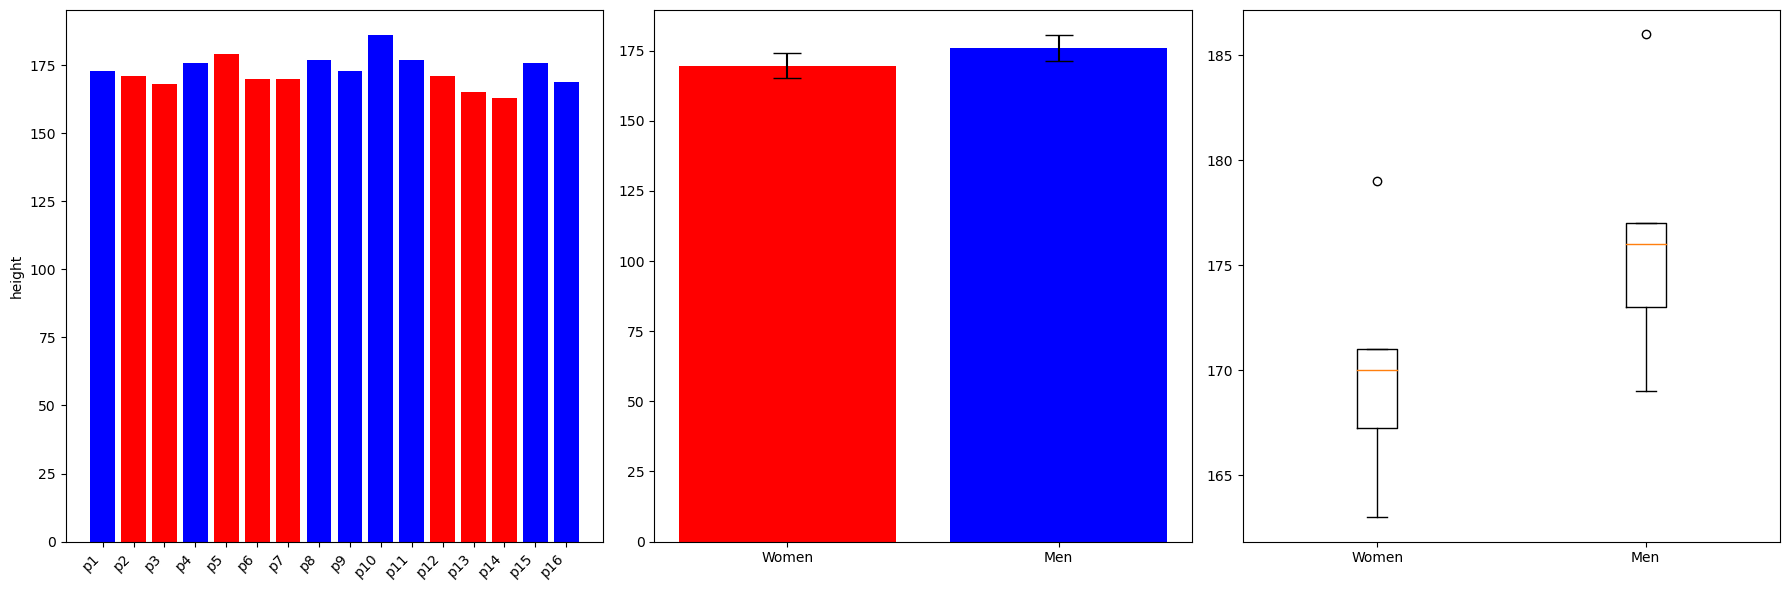

In [21]:
heights = participants['height']

for i, person_name in enumerate(person_names):
    features_dataset = features_dict[person_name]
    height = heights[i]
    features_dataset['height'] = height

plotFeature('height')

# Feature Climbing Level

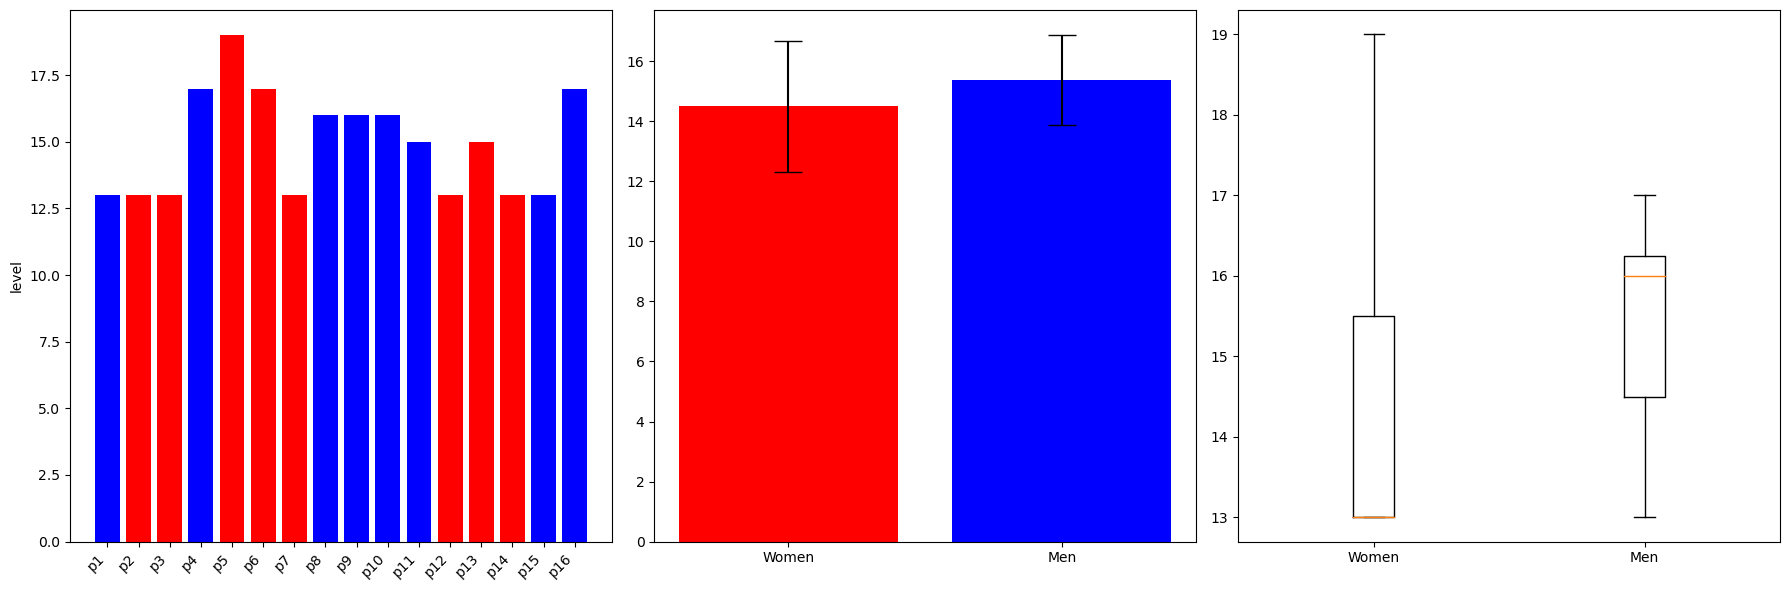

In [22]:
levels = participants['level_ircra']

for i, person_name in enumerate(person_names):
    features_dataset = features_dict[person_name]
    level = levels[i]
    features_dataset['level'] = level

plotFeature('level')

# Feature Climbing Experience

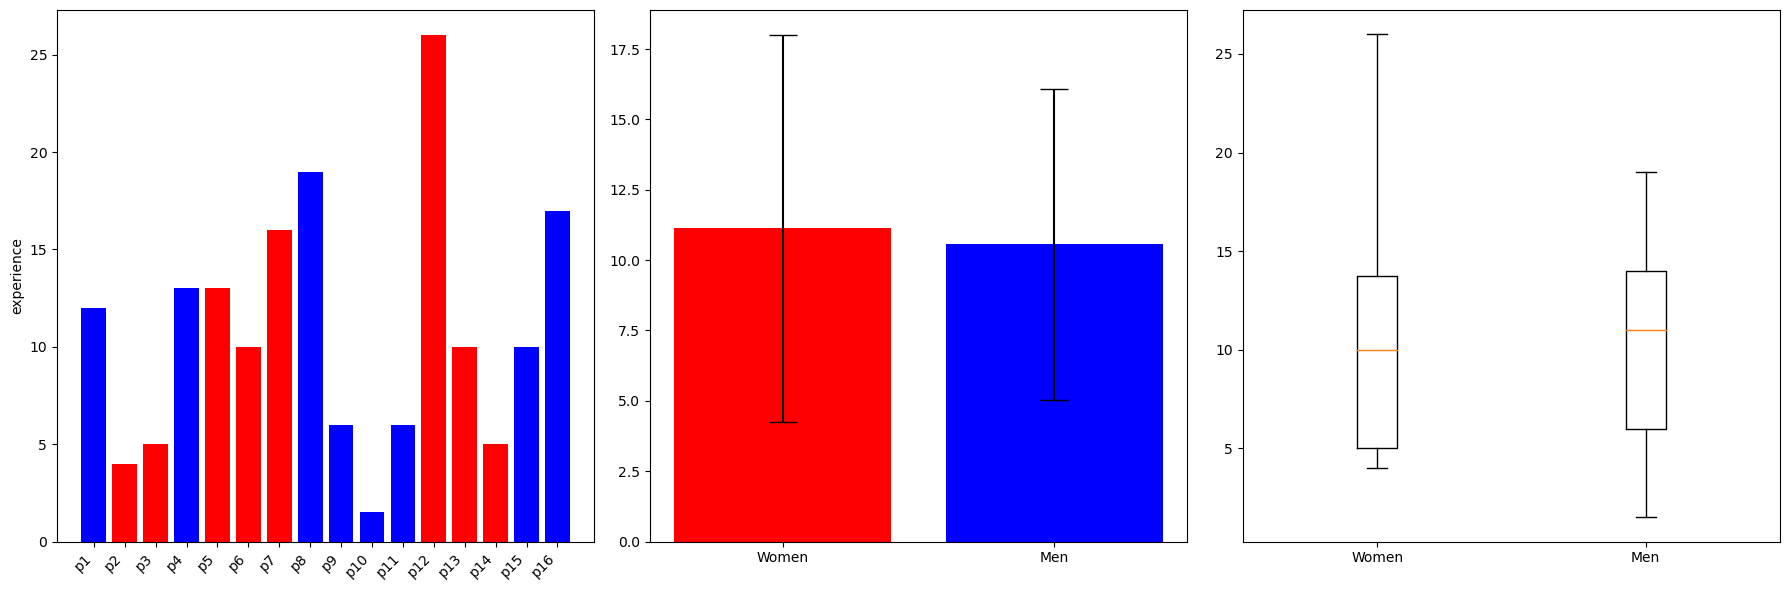

In [23]:
experiences = participants['experience']

for i, person_name in enumerate(person_names):
    features_dataset = features_dict[person_name]
    experience = experiences[i]
    features_dataset['experience'] = experience

plotFeature('experience')

# Feature Trainings per Week

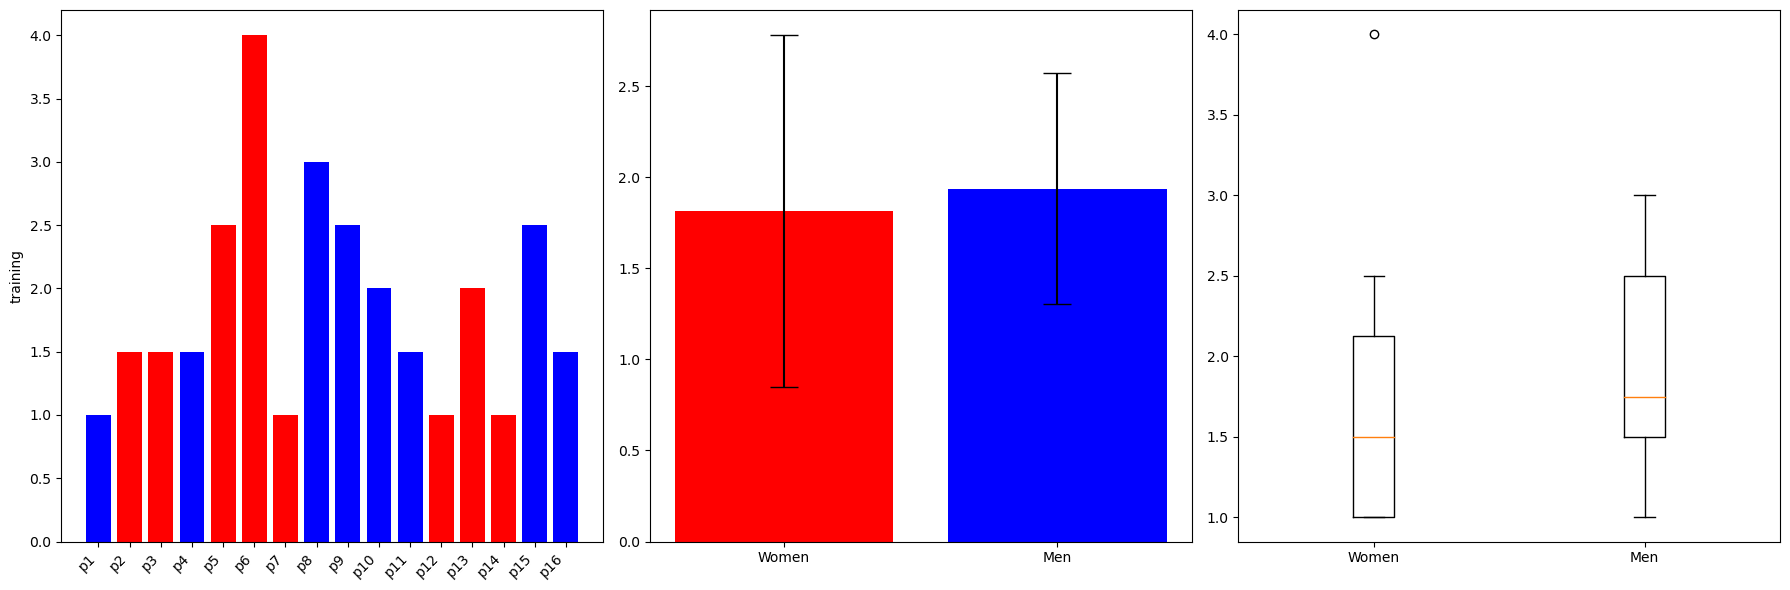

In [24]:
trainings = participants['trainings']

for i, person_name in enumerate(person_names):
    features_dataset = features_dict[person_name]
    training = trainings[i]
    features_dataset['training'] = training

plotFeature('training')

# Feature Age

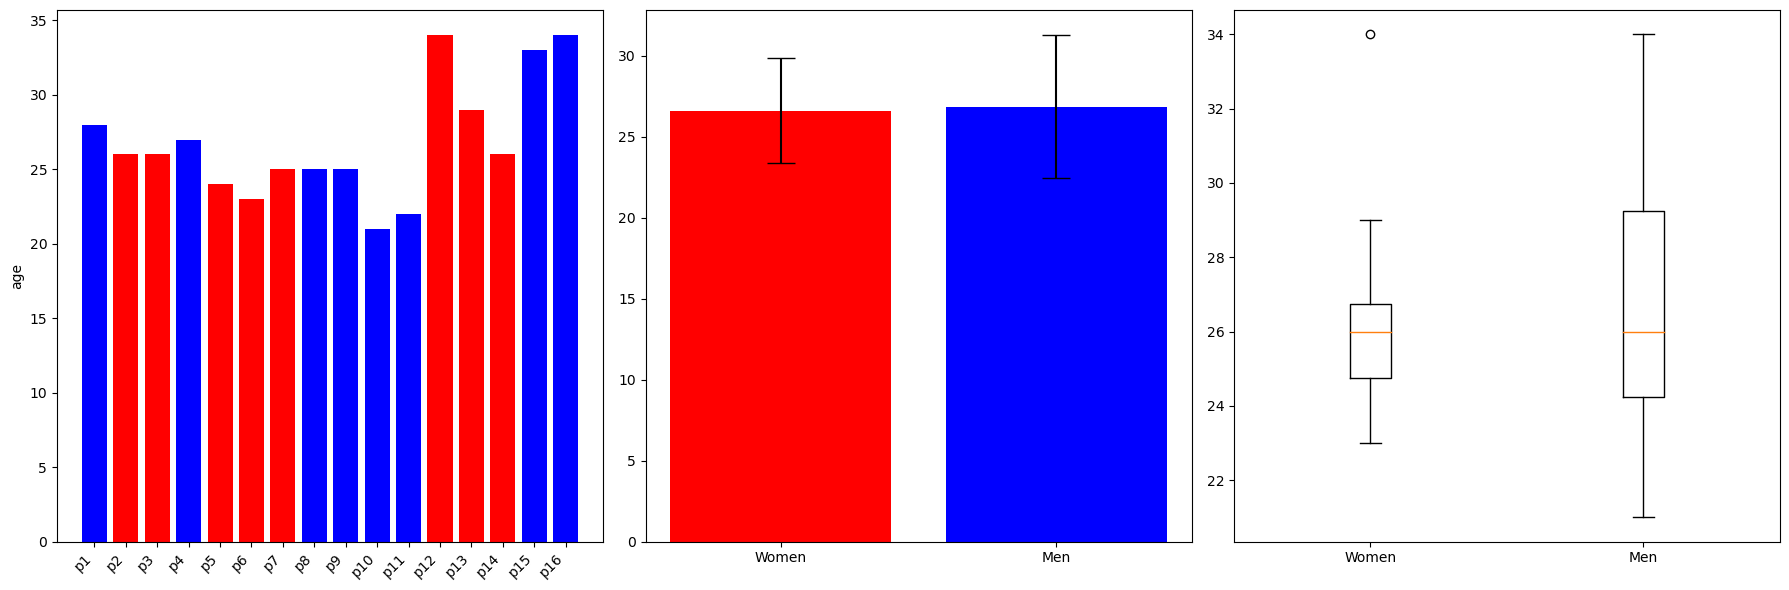

In [25]:
ages = participants['age']

for i, person_name in enumerate(person_names):
    features_dataset = features_dict[person_name]
    age = ages[i]
    features_dataset['age'] = age

plotFeature('age')

In [26]:
# Create an empty list to store dataframes for each person
df_list = []

# Iterate over each person's dataset
for person_name, dataset in features_dict.items():
    person_data = {}
    person_data['person_name'] = person_name
    
    for var_name, var_value in dataset.items():
        # If the variable is a scalar (0-dimensional), directly add its value to the person's data
        if var_value.ndim == 0:
            if var_name == 'gender': 
                person_data[var_name] = 0 if var_value.item() == 'female' else 1
            else:
                person_data[var_name] = var_value.item()
    
    df_list.append(person_data)

# Convert the list of dictionaries to a DataFrame
final_df = pd.DataFrame(df_list)

# Save the DataFrame to a CSV file
final_df.to_csv('features_data.csv', index=False)

# Normalization

In [27]:
min_max_values = {}
features_cluster = {}

for i, person_name in enumerate(person_names):
    acc_dataset = acc_dict[person_name]
    gender = acc_dataset['gender']
    features_cluster[person_name] = xr.Dataset({'gender': gender})

for feature in ['mean_jerk_x', 'mean_jerk_y', 'mean_jerk_z', 'mean_jerk_vector',
                'mean_jerk_1_x', 'mean_jerk_1_y', 'mean_jerk_1_z', 'mean_jerk_1_vector',
                'mean_jerk_2_x', 'mean_jerk_2_y', 'mean_jerk_2_z', 'mean_jerk_2_vector',
                'mean_jerk_3_x', 'mean_jerk_3_y', 'mean_jerk_3_z', 'mean_jerk_3_vector',
                'time', 'time_1', 'time_2', 'time_3',
                'grasping_exploratory', 'grasping_performance', 'grasping_double',
                'pos_peaks', 'pos_peaks_1', 'pos_peaks_2', 'pos_peaks_3',
                'neg_peaks', 'neg_peaks_1', 'neg_peaks_2', 'neg_peaks_3',
                'height', 'level', 'experience', 'training', 'age']:
    # Concatenate all values across all persons for the current feature
    concatenated_data = xr.concat([features_dict[key][feature] for key in features_dict], dim='person')
    
    # Calculate min and max values for the current feature
    min_value = concatenated_data.min()
    max_value = concatenated_data.max()
    
    # Store the min and max values in the dictionary
    min_max_values[feature] = {'min': min_value, 'max': max_value}

    # Normalize the data for each person using the min_max_values
for person_name, dataset in features_dict.items():
    for feature, values in min_max_values.items():
        min_value = values['min']
        max_value = values['max']
        # Normalize the data for the current feature
        features_cluster[person_name][feature] = (dataset[feature] - min_value) / (max_value - min_value)


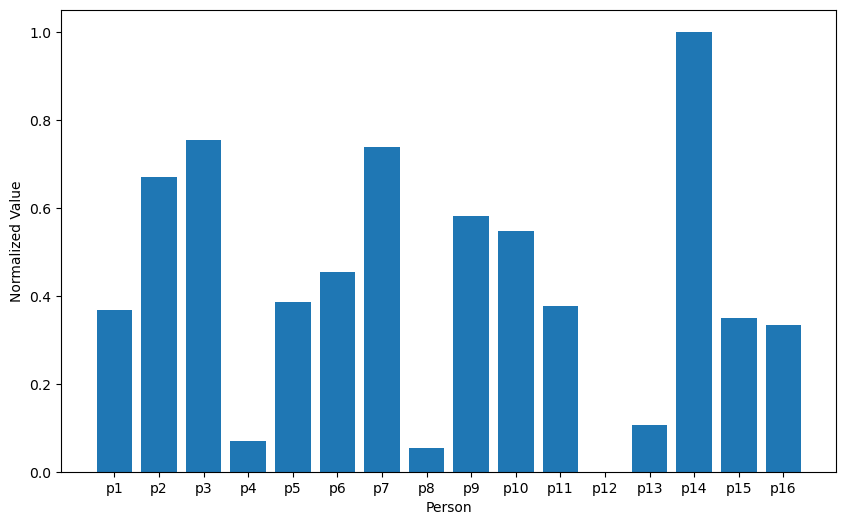

In [28]:
mean_jerk_vector_values = [features_cluster[person_name]['time'].values for person_name in features_dict]

# Plot as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(mean_jerk_vector_values)), mean_jerk_vector_values)
plt.xlabel('Person')
plt.ylabel('Normalized Value')
plt.xticks(range(len(mean_jerk_vector_values)), list(features_dict.keys()))
plt.show()

# Export Data

In [29]:
%store acc_dict
%store features_dict

Stored 'acc_dict' (dict)
Stored 'features_dict' (dict)


In [30]:
# Create an empty list to store dataframes for each person
df_list = []

# Iterate over each person's dataset
for person_name, dataset in features_cluster.items():
    person_data = {}
    person_data['person_name'] = person_name
    
    for var_name, var_value in dataset.items():
        # If the variable is a scalar (0-dimensional), directly add its value to the person's data
        if var_value.ndim == 0:
            if var_name == 'gender': 
                person_data[var_name] = 0 if var_value.item() == 'female' else 1
            else:
                person_data[var_name] = var_value.item()
    
    df_list.append(person_data)

# Convert the list of dictionaries to a DataFrame
final_df = pd.DataFrame(df_list)

# Save the DataFrame to a CSV file
final_df.to_csv('cluster_data.csv', index=False)

In [31]:
# Create an empty list to store dataframes for each person
df_list = []

# Iterate over each person's dataset
for person_name, dataset in features_dict.items():
    person_data = {}
    person_data['person_name'] = person_name
    
    for var_name, var_value in dataset.items():
        # If the variable is a scalar (0-dimensional), directly add its value to the person's data
        if var_value.ndim == 0:
            if var_name == 'gender': 
                person_data[var_name] = 0 if var_value.item() == 'female' else 1
            else:
                person_data[var_name] = var_value.item()
    
    df_list.append(person_data)

# Convert the list of dictionaries to a DataFrame
final_df = pd.DataFrame(df_list)

# Save the DataFrame to a CSV file
final_df.to_csv('features_data.csv', index=False)